In [41]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from patsy import dmatrix

## Data Load

In [1]:
train_16 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'],dtype={'parcelid':int})
prop_16 = pd.read_csv('properties_2016.csv',dtype={'fireplaceflag':object, 'taxdelinquencyflag':object, 'fireplaceflag':object, 'propertyzoningdesc':object, 'propertycountylandusecode':object, 'hashottuborspa':object})
train_df1 = pd.merge(train_16,prop_16,on='parcelid', how ='left')
train_df = train_df1.copy()

# 0.1) Analysis logerror

## 0.1.1) Logerror 

In [156]:
train_df.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

- 2016년의 logerror의 평균값은 보기와 같이 약 0.011로 평균적으로 높은 예측률을 보이고 있음을 알 수 있다.
- logerror의 값이 음수가 나오면, 집값을 낮게 예측한 것으로 underestimate 한 것이다.
- logerror의 값이 양수가 나오면, 집값을 높게 예측한 것으로 overestimate 한 것이다.

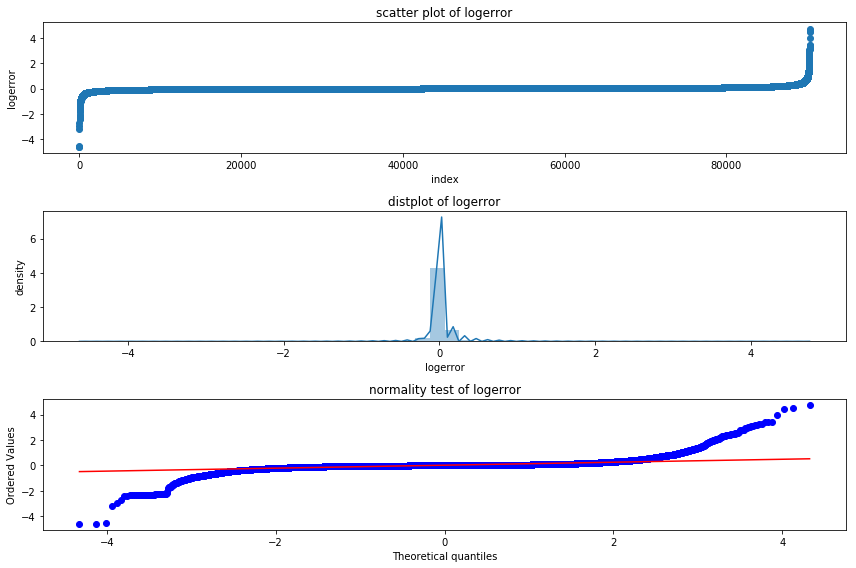

In [157]:
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.scatter(range(len(train_df.logerror)),np.sort(train_df.logerror))
plt.title('scatter plot of logerror')
plt.xlabel('index')
plt.ylabel('logerror')
plt.subplot(312)
sns.distplot(train_df.logerror)
plt.title('distplot of logerror')
plt.xlabel('logerror')
plt.ylabel('density')
plt.subplot(313)
sp.stats.probplot(train_df.logerror,plot=plt)
plt.title('normality test of logerror')
plt.tight_layout()
plt.show()

- logerror의 scatterplot을 보게 되면, 전체적으로 평균값과 가깝게 형성하지만 양 끝(tail)부분에 많이 벗어나는 값들이 존재한다.
- 이에 따라서, logerror의 distplot을 보게 되면 평균값 부근의 첨도는 매우 높게 형성되지만, 양끝의 데이터 분포가 넓게 형성된다.
- probplot을 통해 보는 약식의 정규성 test에서도 넓게 분산된 극단치로 인해서 정규성 형성이 안되는 것을 알 수 있다.

## 0.1.2) Absolute Logerror

In [158]:
(np.abs(train_df.logerror)).describe()

count    90275.000000
mean         0.068447
std          0.146262
min          0.000000
25%          0.013900
50%          0.032500
75%          0.069400
max          4.737000
Name: logerror, dtype: float64

- 이번에는 절댓값을 취한 logerror에 대한 분포이다.
- absolute logerror에서는 양수면 zestimation과 houseprice값의 error 자체가 크다는 것을 의미한다.
- 평균값은 0.06으로 절댓값을 취하지 않은 샘플값보다 높게 나온 것을 보아 이전의 통계량은 음수와 양수가 상쇄(offsetting)이 되었음을 알 수 있다.

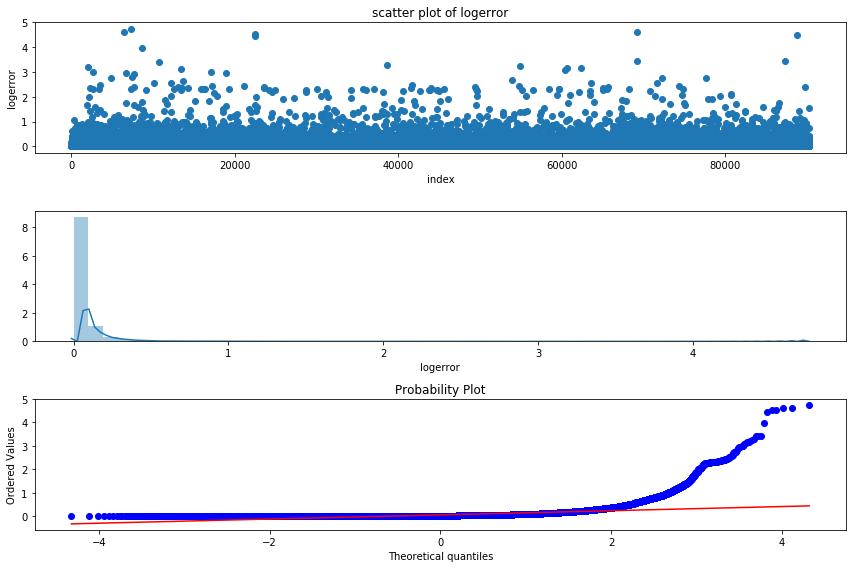

In [159]:
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.scatter(range(len(train_df.logerror)),np.abs(train_df.logerror))
plt.title('scatter plot of logerror')
plt.xlabel('index')
plt.ylabel('logerror')
plt.subplot(312)
sns.distplot(np.abs(train_df.logerror))
plt.subplot(313)
sp.stats.probplot(np.abs(train_df.logerror),plot=plt)
plt.tight_layout()
plt.show()

# 0.2) Transactiondate

In [160]:
train_df_month = train_df.copy()
train_df_month.transactiondate = train_df_month.transactiondate.dt.month
train_df_month = train_df_month.iloc[:,1:3]
train_df_month.head()
# train_df_month dataframe을 logerror와 transactiondate의 month 속성만 가지게 한다.

,logerror,transactiondate
0,0.0276,1
1,-0.1684,1
2,-0.0040,1
3,0.0218,1
4,-0.0050,1


In [161]:
train_df_month = train_df_month.groupby(by='transactiondate').agg('mean').reset_index()
train_df_month
# transaction date를 월 별로 정렬하고 그에 따른 logerror의 평균값을 구해 groupby

,transactiondate,logerror
0,1,0.015870
1,2,0.016082
2,3,0.009867
3,4,0.006605
4,5,0.006926
5,6,0.007172
6,7,0.011687
7,8,0.011573
8,9,0.016255
9,10,0.016342


## 0.2.1) Changes in transaction over time

#### trainsactiondate를 month 단위로 변환시켜서 그에 따른 logerror의 변화와, trainsaction 자체의 volumn에 대해서 알아보겠다.

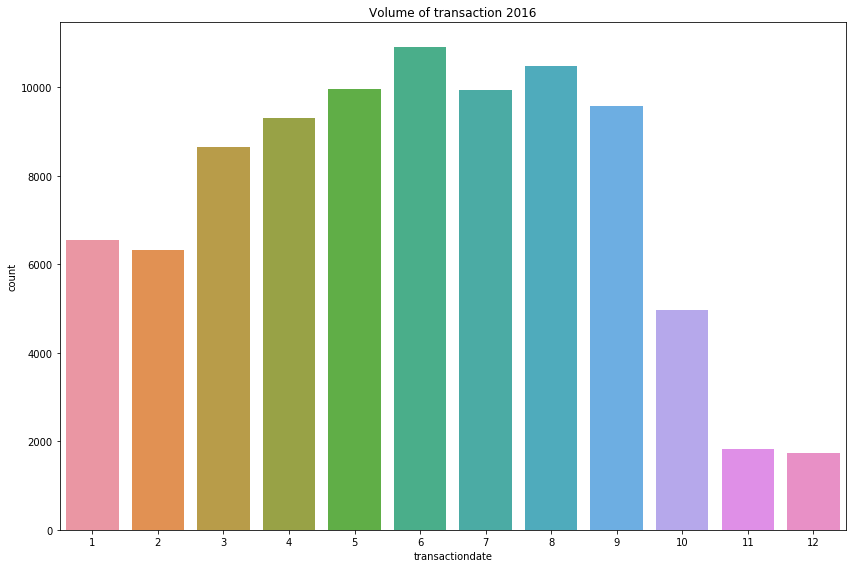

In [162]:
plt.figure(figsize=(12,8))
sns.countplot(train_df.transactiondate.dt.month,data=train_df)
plt.title('Volume of transaction 2016')
plt.tight_layout()
plt.show()

- 위의 표는 2016년 월별 거래량을 보여주는 플롯으로 날이 따듯해지는 봄부터 추워지기 전까지인 9월까지 거래가 눈에 띄게 많이 일어남을 알 수 있다.

## 0.2.2) Changes in Logerror over times(Month)

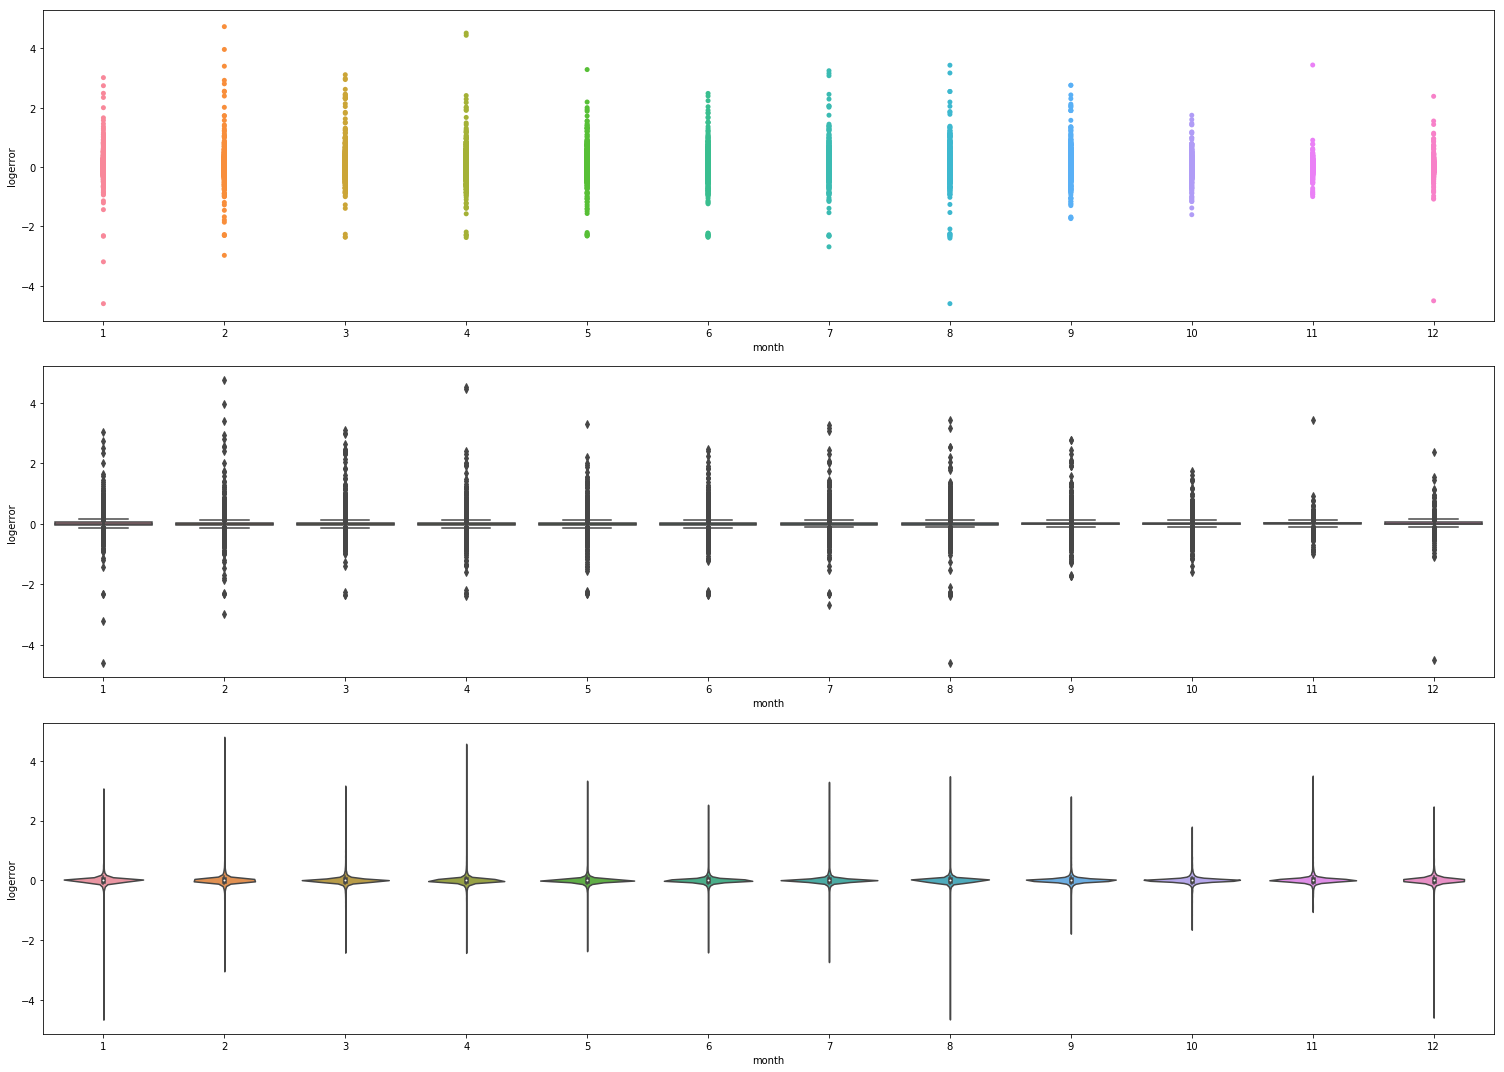

In [163]:
plt.figure(figsize=(21,15))
plt.subplot(311)
sns.stripplot(train_df.transactiondate.dt.month,train_df.logerror,data=train_df)
plt.xlabel('month')
plt.ylabel('logerror')
plt.subplot(312)
sns.boxplot(train_df.transactiondate.dt.month,train_df.logerror,data=train_df)
plt.xlabel('month')
plt.ylabel('logerror')
plt.subplot(313)
sns.violinplot(train_df.transactiondate.dt.month,train_df.logerror,data=train_df)
plt.xlabel('month')
plt.ylabel('logerror')
plt.tight_layout()
plt.show()

- 2016년 월별 대비 logerror의 분포를 나타내는 stripplot과 bloxplot, violinplot이다.
- 달이 변화함에 따라, 즉 시간이 변화함에 따라서 logerror자체의 density의 변화나 평균값이 거의 달라지지 않음을 알 수 있다.
- logerror 자체적인 분포에서도 알 수 있었지만, 위의 표를 보게 되면, 극단값이 존재하지만, 평균값 주변의 density가 상대적으로 매우 높다. 즉, 첨도가 매우 높다.

# 0.3) Parcelid

## 0.3.1) How many times parcelid data are duplicated

In [164]:
train_df_id = (train_df.parcelid.value_counts().reset_index()).groupby(by='parcelid').agg('size').reset_index()
train_df_id.columns = ['Overlapped_Times','Count']
train_df_id

,Overlapped_Times,Count
0,1,90026
1,2,123
2,3,1


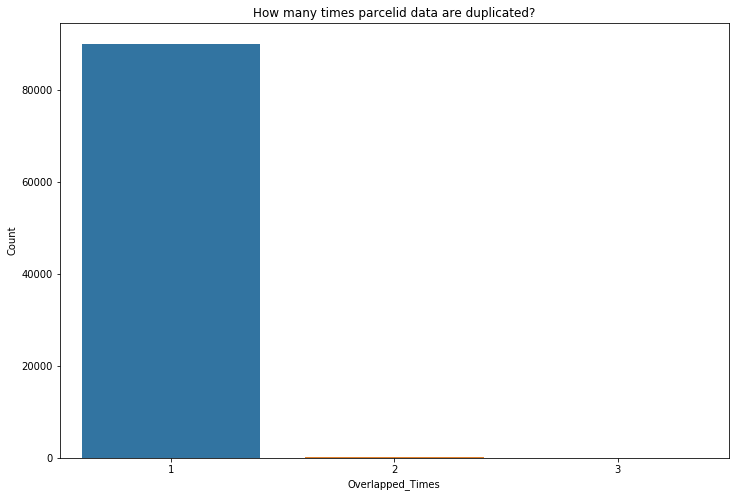

In [165]:
plt.figure(figsize=(12,8))
sns.barplot(train_df_id.Overlapped_Times,train_df_id.Count)
plt.title('How many times parcelid data are duplicated?')
plt.xlabel(train_df_id.columns[0])
plt.ylabel(train_df_id.columns[1])
plt.show()

- 중복되는 parcelid의 데이터가 있지만 위의 bar plot에서 볼 수 있다시피, 상대적으로 중복되는 데이터가 거의 없다고 할 수 있다.
- 따라서 각각의 ID가 unique하다고 간주하고 분석을 진행해도 무방하다고 판단한다.

# 1) Analysis Features

## 1.1.1) Overview the Inner-feature data
- inner_feature는 총 18개의 컬럼으로 이뤄져 있고, 분류 기준은 집 구성하는 미시적 요소들에 관한 것이다.
- 화장실 갯수를 의미하는 컬럼이 중복된다.(bathroomcnt, calculatebathnbr)

- 'architecturalstyletypeid'
- 'bathroomcnt'
- 'calculatedbathnbr'
- 'threequarterbathnbr'
- 'fullbathcnt'
- 'bedroomcnt'
- 'roomcnt’
- 'garagecarcnt'
- 'garagetotalsqft'
- 'airconditioningtypeid'
- 'fireplacecnt'
- 'fireplaceflag'
- 'hashottuborspa'
- 'heatingorsystemtypeid'
- 'poolcnt'
- 'poolsizesum'
- 'pooltypeid10'
- 'pooltypeid2'
- 'pooltypeid7'

In [2]:
inner_feature= [
    '에어컨 아이디',
    '화장실 갯수',
    '화장실 갯수',
    '집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)',
    '풀옵션 화장실의 갯수',
    '침실 갯수',
     '주거지에있는 총 객실 수',
    '차고 갯수',
    '차고 평방(크기)',
    '에이컨 아이디',
    '벽난로 수',
    '벽난로가 있는지 없는지',
    '난방 시스템의 유무',
    '난방 시스템의 타입',
    '수영장 갯수',
    '수영장 크기',
     '스파 또는 온천',
     '스파 / 온수 욕조가있는 수영장',
    ' 온수 욕조가없는 수영장'
]

inner_feature_col=[
'airconditioningtypeid',
'bathroomcnt',
'calculatedbathnbr',
'threequarterbathnbr',
'fullbathcnt',
'bedroomcnt',
'roomcnt',
'garagecarcnt',
'garagetotalsqft',
'airconditioningtypeid',
'fireplacecnt',
'fireplaceflag',
'hashottuborspa',
'heatingorsystemtypeid',
'poolcnt',
'poolsizesum',
'pooltypeid10',
'pooltypeid2',
'pooltypeid7'
]

In [3]:
inner_df = pd.DataFrame(columns=['name','feature'])
inner_df.name = inner_feature_col
inner_df.feature = inner_feature
inner_df

,name,feature
0,airconditioningtypeid,에어컨 아이디
1,bathroomcnt,화장실 갯수
2,calculatedbathnbr,화장실 갯수
3,threequarterbathnbr,집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
4,fullbathcnt,풀옵션 화장실의 갯수
5,bedroomcnt,침실 갯수
6,roomcnt,주거지에있는 총 객실 수
7,garagecarcnt,차고 갯수
8,garagetotalsqft,차고 평방(크기)
9,airconditioningtypeid,에이컨 아이디


## 1.1.2) Overview the Outer-feature data
- outer feature는 총 12개의 컬럼으로 이뤄져 있고, 분류 기준은 집의 전체적인 구조(structure)적인 부분에서 관찰될 수 있는 특징에 관한 것입니다.

- 'architecturalstyletypeid'
- 'buildingqualitytypeid'
- 'buildingclasstypeid'
- 'decktypeid'
- 'numberofstories'
- 'storytypeid'
- 'typeconstructiontypeid'
- 'unitcnt'
- 'yardbuildingsqft17'
- 'yardbuildingsqft26'
- 'yearbuilt'

In [5]:
outer_feature=[
'건축 양식 아이디',
'건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)',
'건물 뼈대에 어떤 타입의 재료가 쓰였는지',
'집 마당 부근에 있는 갑판(테라스같은 것을 의미)',
'집의 층 수 (story or level이라고 표현한다.)',
'집의 층 수 (story or level이라고 표현한다.)',
'주택 건설에 사용 된 건축 자재의 유형',
'구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)',
'주거지가 지어진 해']
outer_feature_col = [
'architecturalstyletypeid',
'buildingqualitytypeid',
'buildingclasstypeid',
'decktypeid',
'numberofstories',
'storytypeid',
'typeconstructiontypeid',
'unitcnt',
'yearbuilt']

In [6]:
outer_df = pd.DataFrame(columns=['name','feature'])
outer_df.name = outer_feature_col
outer_df.feature = outer_feature
outer_df

,name,feature
0,architecturalstyletypeid,건축 양식 아이디
1,buildingqualitytypeid,건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)
2,buildingclasstypeid,건물 뼈대에 어떤 타입의 재료가 쓰였는지
3,decktypeid,집 마당 부근에 있는 갑판(테라스같은 것을 의미)
4,numberofstories,집의 층 수 (story or level이라고 표현한다.)
5,storytypeid,집의 층 수 (story or level이라고 표현한다.)
6,typeconstructiontypeid,주택 건설에 사용 된 건축 자재의 유형
7,unitcnt,"구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)"
8,yearbuilt,주거지가 지어진 해


## 1.1.3) Overview the Region-feature data
- region feature는 총 12 개의 컬럼으로 이뤄져있고, 분류 기준은 지역, 주소, 부동산에 관련된 것으로 통합적으로 지역에 관련된 컬럼입니다.

- Title :` <real estate feature>`
- 'propertycountylandusecode'
- 'propertylandusetypeid'
- 'propertyzoningdesc'
- 'rawcensustractandblock'
- 'censustractandblock'
-  Title : `< Location feature>`
- 'latitude'
- 'longitude'
- Title : `<address feature>`
- 'fips'
- 'regionidcounty'
- 'regionidcity'
- 'regionidzip'
- 'regionidneighborhood'
- `initially, I divided three features named region, location,adress but, I'd like to try three things into one characteristic in this EDA.`

In [9]:
region_feature = [
    'county land use code : 지역이 어떻게 개발되고 사용될 지에 대한 regulation',
     '토지가 어떻게 사용되는지에 대한 타입',
     '해당 부동산에 대해 허용 된 토지 용도 (구역 설정)에 대한 설명',
    'Raw Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함',
     'Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함',
     '소포 중도 위도에 10e6을 곱한 값',
     '소포 중도 경도에 10e6을 곱한 값',
    '연방 정보 처리 규정(연방에서 해당 지역을 어떻게 정보 처리하는지에 대한 것)',
     '해당 부동산이 위치하는 카운티(county:Second-level administrative division)',
     '해당 부동산이있는 도시 (있는 경우)',
    '해당 부동산이 위치한 우편 번호',
    '해당 부동산이 위치한 동네'
]
region_feature_col = [
    'propertycountylandusecode',
    'propertylandusetypeid',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'censustractandblock',
    'latitude',
    'longitude',
    'fips',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood'
]

In [10]:
region_df = pd.DataFrame(columns=['name','feature'])
region_df.name = region_feature_col
region_df.feature = region_feature
region_df

,name,feature
0,propertycountylandusecode,county land use code : 지역이 어떻게 개발되고 사용될 지에 대한 ...
1,propertylandusetypeid,토지가 어떻게 사용되는지에 대한 타입
2,propertyzoningdesc,해당 부동산에 대해 허용 된 토지 용도 (구역 설정)에 대한 설명
3,rawcensustractandblock,Raw Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할...
4,censustractandblock,Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함
5,latitude,소포 중도 위도에 10e6을 곱한 값
6,longitude,소포 중도 경도에 10e6을 곱한 값
7,fips,연방 정보 처리 규정(연방에서 해당 지역을 어떻게 정보 처리하는지에 대한 것)
8,regionidcounty,해당 부동산이 위치하는 카운티(county:Second-level administr...
9,regionidcity,해당 부동산이있는 도시 (있는 경우)


## 1.1.4) Overview the Tax-feature data

- 'taxvaluedollarcnt'
- 'structuretaxvaluedollarcnt'
- 'landtaxvaluedollarcnt'
- 'taxamount'
- 'assessmentyear'
- 'taxdelinquencyflag'
- 'taxdelinquencyyear'

In [11]:
tax_feature = [
    '소포의 총 세금 평가 가치',
    '소포에 건설 된 구조물의 평가 된 가치',
    '소포의 토지 면적에 대한 평가 된 가치',
    '해당 평가 연도에 대해 평가 된 총 재산세',
    '재산세 산정 년도',
    '이 소포의 재산세는 2015 년까지 만기가됩니다.',
    '미납 된 재산세 납부시기'
]
tax_feature_col = [
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount',
    'assessmentyear',
    'taxdelinquencyflag',
    'taxdelinquencyyear'
]

In [12]:
tax_df = pd.DataFrame(columns=['name','feature'])
tax_df.name = tax_feature_col
tax_df.feature = tax_feature
tax_df

,name,feature
0,taxvaluedollarcnt,소포의 총 세금 평가 가치
1,structuretaxvaluedollarcnt,소포에 건설 된 구조물의 평가 된 가치
2,landtaxvaluedollarcnt,소포의 토지 면적에 대한 평가 된 가치
3,taxamount,해당 평가 연도에 대해 평가 된 총 재산세
4,assessmentyear,재산세 산정 년도
5,taxdelinquencyflag,이 소포의 재산세는 2015 년까지 만기가됩니다.
6,taxdelinquencyyear,미납 된 재산세 납부시기


## 1.1.5) Overview the SQFT-feature data

- 'basementsqft'
- 'finishedfloor1squarefeet'
- 'calculatedfinishedsquarefeet'
- 'finishedsquarefeet6'
- 'finishedsquarefeet12'
- 'finishedsquarefeet13'
- 'finishedsquarefeet15'
- 'finishedsquarefeet50'
- 'lotsizesquarefeet'

In [13]:
sqrt_feature= [
    '지하 square foot(평수를 의미)',
    '집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)',
    '가정의 첫 번째 (출입국) 층에있는 완숙 지역의 크기',
    '미완성 완전 공간 지역',
    '완성된 주요 주거 공간',
    '주변 생활 공간',
    '전체 면적',
    '1층 면적',
   ' 로트 면적(lot는 area of zoning lot을 의미한다.)',
    '마당 안뜰',
    '저장고/야적장'
]
sqrt_feature_col =[
    'basementsqft',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'lotsizesquarefeet',
    'yardbuildingsqft17',
    'yardbuildingsqft26'
]

In [14]:
sqrt_df = pd.DataFrame(columns=['name','feature'])
sqrt_df.name = sqrt_feature_col
sqrt_df.feature = sqrt_feature
sqrt_df

,name,feature
0,basementsqft,지하 square foot(평수를 의미)
1,finishedfloor1squarefeet,집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
2,calculatedfinishedsquarefeet,가정의 첫 번째 (출입국) 층에있는 완숙 지역의 크기
3,finishedsquarefeet6,미완성 완전 공간 지역
4,finishedsquarefeet12,완성된 주요 주거 공간
5,finishedsquarefeet13,주변 생활 공간
6,finishedsquarefeet15,전체 면적
7,finishedsquarefeet50,1층 면적
8,lotsizesquarefeet,로트 면적(lot는 area of zoning lot을 의미한다.)
9,yardbuildingsqft17,마당 안뜰


## 1.2) Datatype of Columns

### Inner-feature
- Inner_feature에는 18개의 컬럼이 있고, 2개의 object 자료형과 16개의 float형이 있다.
- numerical data, object data 를 가지고 있는 컬럼들을 나눠서 분석을 하도록 하겠다.

In [23]:
print(train_df[inner_feature_col].dtypes,end='\n\n'),
print('Number of Inner_feature_col:  {}'.format(len(inner_feature_col)))

airconditioningtypeid    float64
bathroomcnt              float64
calculatedbathnbr        float64
threequarterbathnbr      float64
fullbathcnt              float64
bedroomcnt               float64
roomcnt                  float64
garagecarcnt             float64
garagetotalsqft          float64
airconditioningtypeid    float64
fireplacecnt             float64
fireplaceflag             object
hashottuborspa            object
heatingorsystemtypeid    float64
poolcnt                  float64
poolsizesum              float64
pooltypeid10             float64
pooltypeid2              float64
pooltypeid7              float64
dtype: object

Number of Inner_feature_col:  19


In [27]:
inner_numeric = []
inner_object = []
for col in inner_feature_col:
    if train_df[col].dtypes == 'float64':
        inner_numeric.append(col)
    else:inner_object.append(col)

In [28]:
inner_numeric
print(len(inner_numeric))

17


In [29]:
inner_object
print(len(inner_object))

2


### Outer-feature
- outer_feature에는 9개의 컬럼이 있고, 모두 float형이다.

In [22]:
print(train_df[outer_feature_col].dtypes,end='\n\n'),
print('Number of Outer_feature_col:  {}'.format(len(outer_feature_col)))

architecturalstyletypeid    float64
buildingqualitytypeid       float64
buildingclasstypeid         float64
decktypeid                  float64
numberofstories             float64
storytypeid                 float64
typeconstructiontypeid      float64
unitcnt                     float64
yearbuilt                   float64
dtype: object

Number of Outer_feature_col:  9


### Region-feature
- Inner_feature에는 12개의 컬럼이 있고, 2개의 object 자료형과 10개의 float형이 있다.
- numerical data, object data 를 가지고 있는 컬럼들을 나눠서 분석을 하도록 하겠다.

In [30]:
print(train_df[region_feature_col].dtypes,end='\n\n'),
print('Number of Region_feature_col:  {}'.format(len(region_feature_col)))

propertycountylandusecode     object
propertylandusetypeid        float64
propertyzoningdesc            object
rawcensustractandblock       float64
censustractandblock          float64
latitude                     float64
longitude                    float64
fips                         float64
regionidcounty               float64
regionidcity                 float64
regionidzip                  float64
regionidneighborhood         float64
dtype: object

Number of Region_feature_col:  12


In [31]:
region_numeric = []
region_object = []
for col in region_feature_col:
    if train_df[col].dtypes == 'float64':
        region_numeric.append(col)
    else:region_object.append(col)

In [32]:
region_numeric
print(len(region_numeric))

10


In [33]:
region_object
print(len(region_object))

2


### Tax-feature
- Tax_feature에는 7개의 컬럼이 있고, 1개의 object 자료형과 6개의 float형이 있다.
- numerical data, object data 를 가지고 있는 컬럼들을 나눠서 분석을 하도록 하겠다.

In [24]:
print(train_df[tax_feature_col].dtypes,end='\n\n'),
print('Number of Tax_feature_col:  {}'.format(len(tax_feature_col)))

taxvaluedollarcnt             float64
structuretaxvaluedollarcnt    float64
landtaxvaluedollarcnt         float64
taxamount                     float64
assessmentyear                float64
taxdelinquencyflag             object
taxdelinquencyyear            float64
dtype: object

Number of Tax_feature_col:  7


In [34]:
tax_numeric = []
tax_object = []
for col in tax_feature_col:
    if train_df[col].dtypes == 'float64':
        tax_numeric.append(col)
    else:tax_object.append(col)

In [35]:
tax_numeric
print(len(tax_numeric))

6


In [36]:
tax_object
print(len(tax_object))

1


### Sqft-feature
- SQRT_feature에는 11개의 컬럼이 있고, 모두 float형이다.

In [25]:
print(train_df[sqrt_feature_col].dtypes,end='\n\n'),
print('Number of Sqrt_feature_col:  {}'.format(len(sqrt_feature_col)))

basementsqft                    float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet6             float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
lotsizesquarefeet               float64
yardbuildingsqft17              float64
yardbuildingsqft26              float64
dtype: object

Number of Sqrt_feature_col:  11


## 1.3.1) Individual columns' feature analysis -- Inner-feature

### scatter plot about numerical data

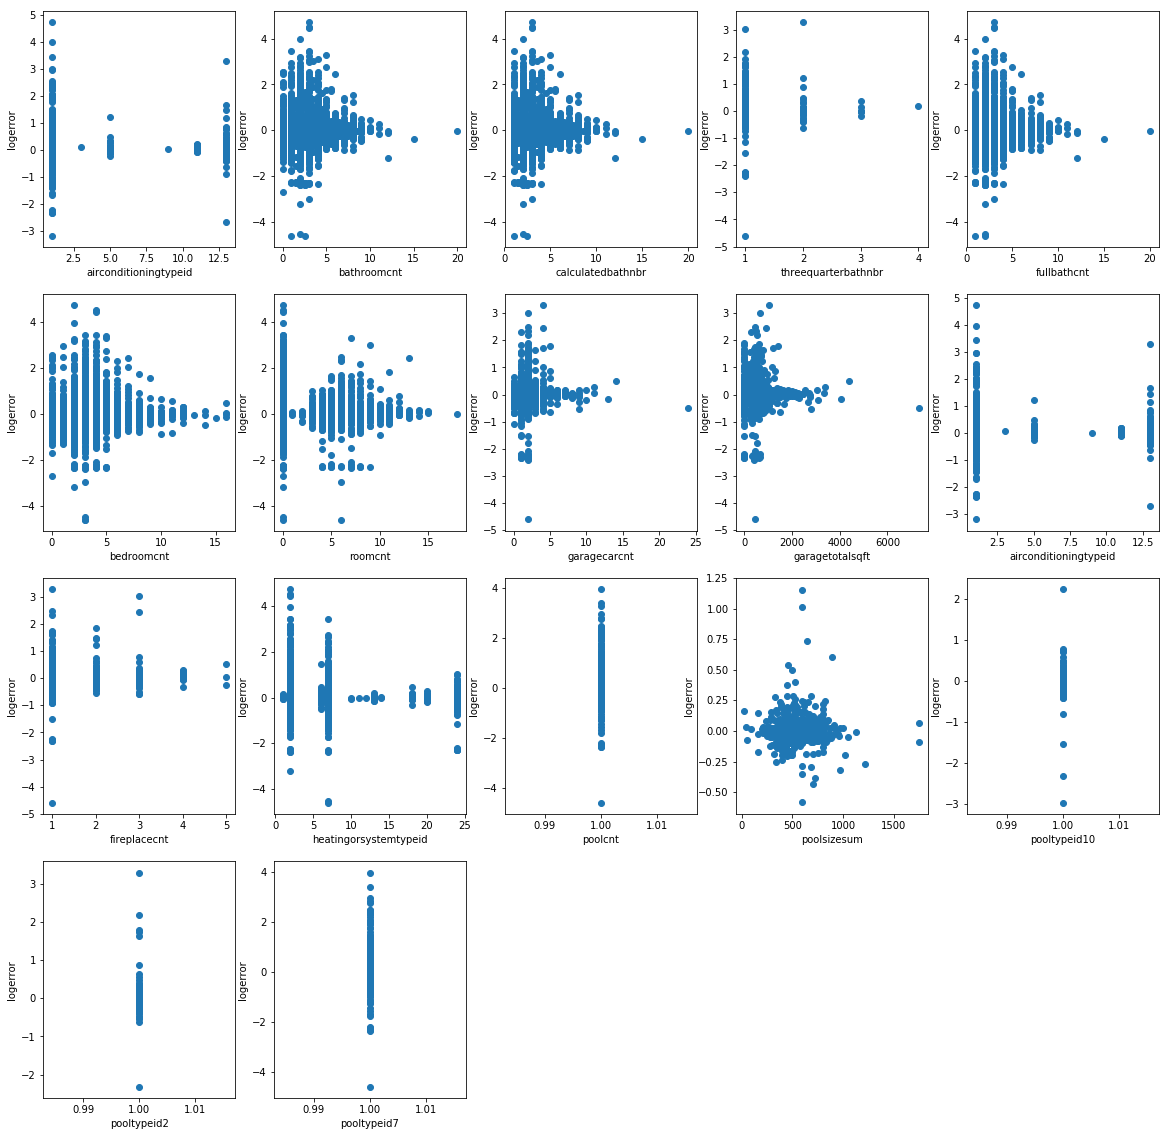

In [37]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_numeric):
    plt.subplot(4,5,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- float 자료형에 대한 scatterplot을 그려본 결과 대부분의 분포 형태가 continuous하지 않고, discrete한 분포를 띄고 있다고 보여진다.
- 즉, numeric category를 가지고 있을 수 있는 컬럼이라고 생각하고, 카테고리의 갯수를 40개 미만으로 가지는 데이터에 대해서 다시 분포에 대해 시각화해본다.

In [47]:
discrete_inner_col = []
for idx,col in enumerate(inner_numeric):
    if len(train_df[col].value_counts())<40:
        discrete_inner_col.append(col)
len(discrete_inner_col)

15

#### 40 개 미만의 카테고리를 가지는 discrete data column 이 총 15개가 나왔다. discrete data column의 stripplot,viloinplot

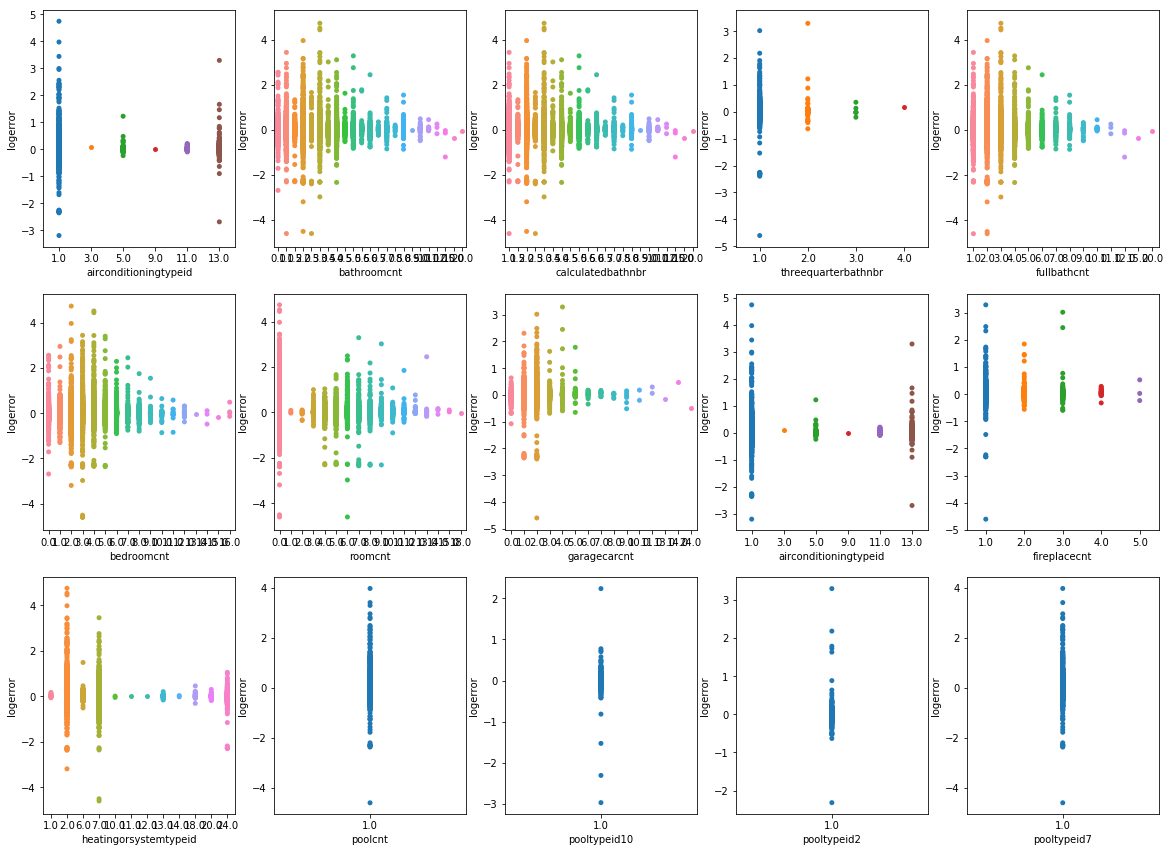

In [42]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_inner_col):
    plt.subplot(4,5,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- 카테고리가 하나인 컬럼들이 존재한다.
- 카테고리와 분포도를 감안하고 곧 실시할 missing_value가 얼마나 차지할지를 고려하여서 Data cleaning을 실시

#### 마지막으로, object datatype을 가지는 컬럼 2개에 대해서도 countplot으로 시각화를 한다.

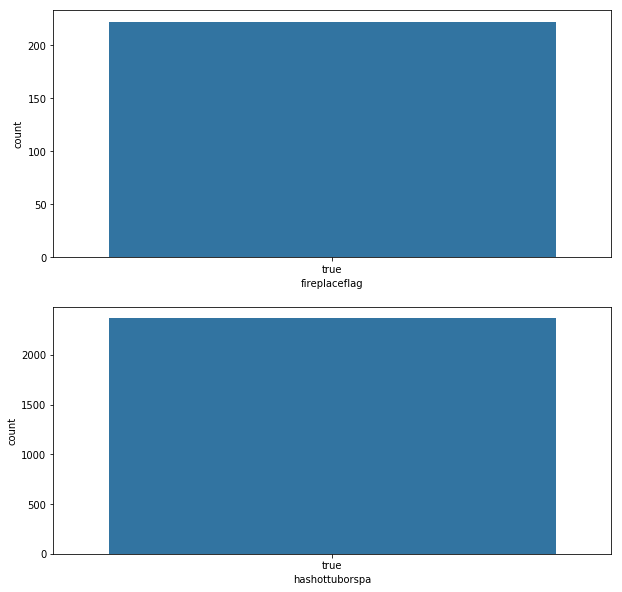

In [45]:
plt.figure(figsize=(10,10))
for idx,col in enumerate(inner_object):
    plt.subplot(2,1,idx+1)
    sns.countplot(train_df[col],data=train_df)
    plt.xlabel(col)
    plt.ylabel('count')
plt.show()

- object datatype에 대한 column 의 countplot을 보면, 카테고리가 하나다. 
- 곧 실시할 data cleaning에서의 imputation strategy에 참고해야 할 사항이다.

## 1.3.2) Individual columns' feature analysis -- Outer-feature

### scatter plot about numerical data

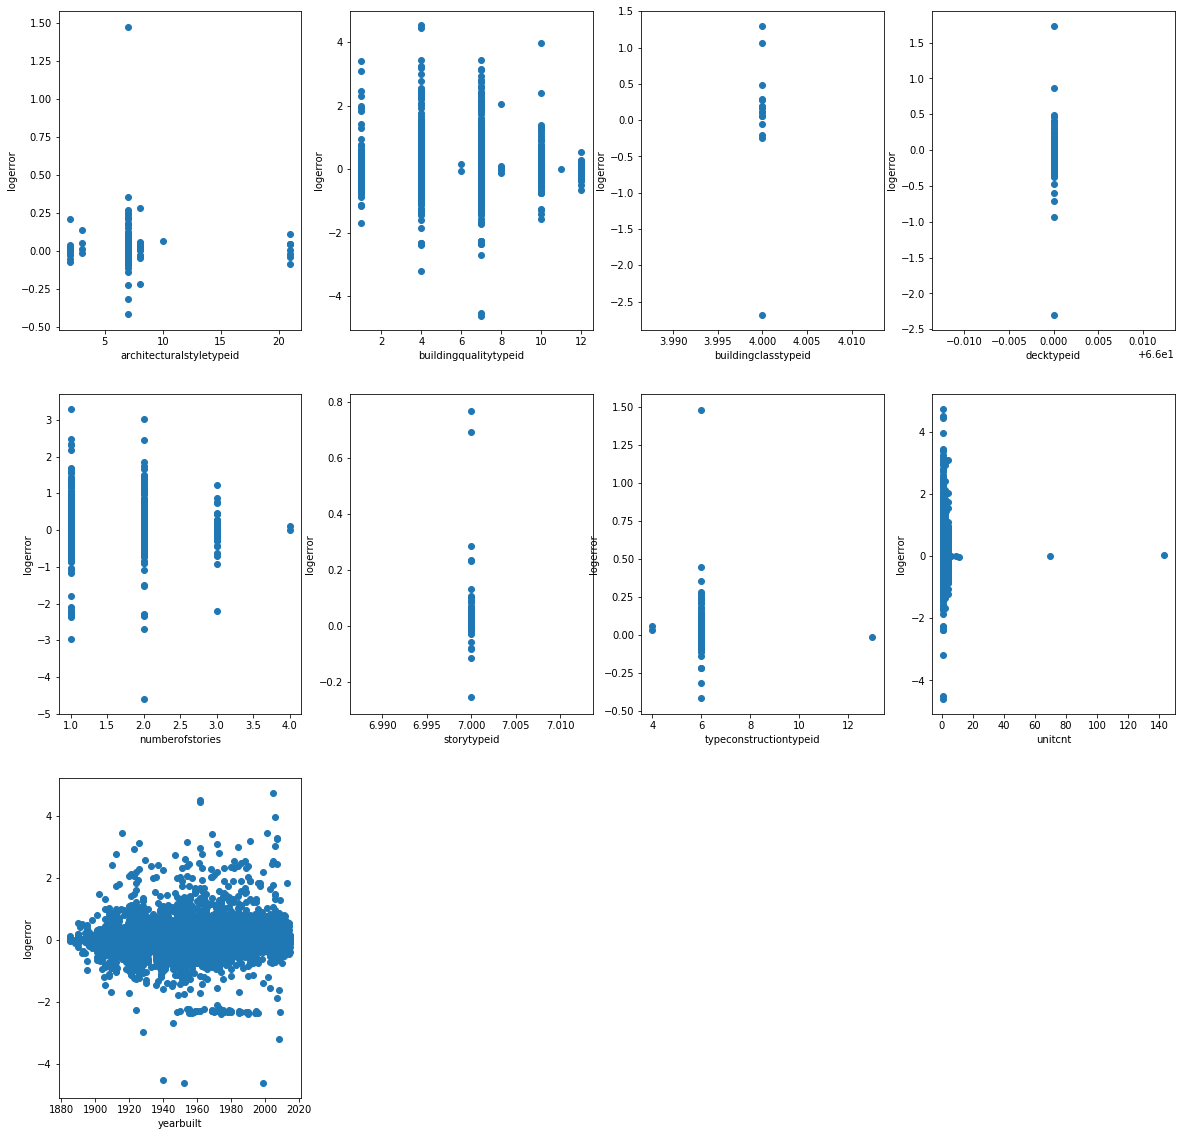

In [48]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(outer_feature_col):
    plt.subplot(3,4,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- 자료형은 numerical data로 나왔지만 scatter plot으로 봤을 때, 분포도가 continuous 하지 않고 discrete한 데이터라는 것을 알 수 있다.
- discrete data는 float형으로 이뤄진 category를 가지고 있다고 할 수 있고, 이는 후에 나올 data cleaning에도 유의하게 보아야 할 정보다.
- 이러한 자료들을 value_counts 명령어로 확인해보겠다. discrete 한지 안한지에 대해서 기준을 두는데, 그 기준은 category가 40개를 넘지 않는 것으로 하겠다.

####  위의 조건을 만족하는 컬럼을 discrete_outer_col이라는 리스트에 넣고 이 컬럼들을 시각화해보겠다.

In [49]:
discrete_outer_col = []
for idx,col in enumerate(outer_feature_col):
    if len(train_df[col].value_counts())<40:
        discrete_outer_col.append(col)
len(discrete_outer_col)

8

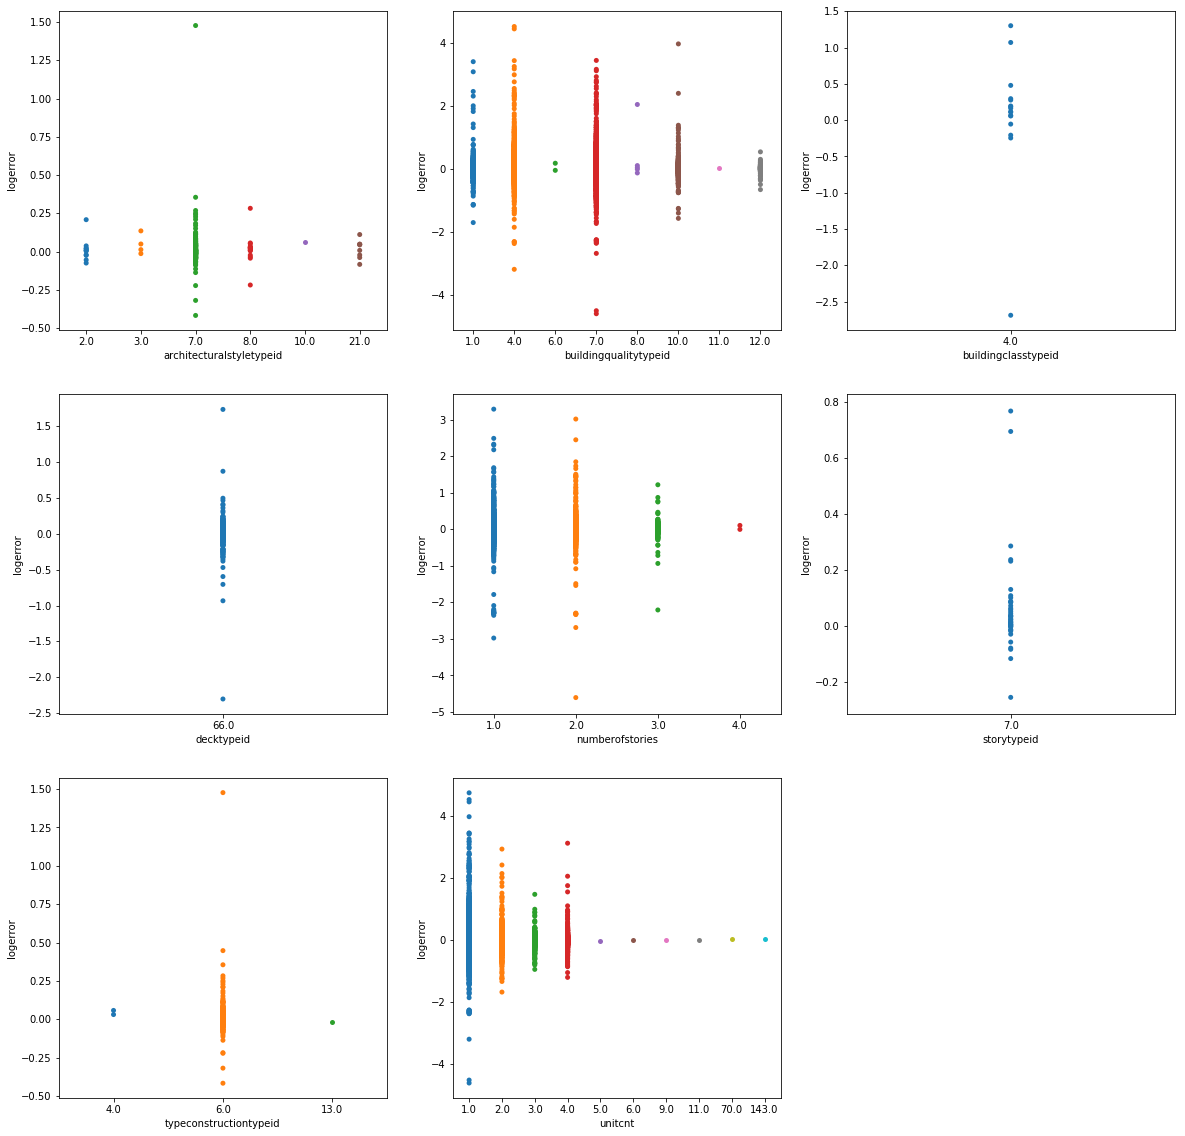

In [50]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_outer_col):
    plt.subplot(3,3,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

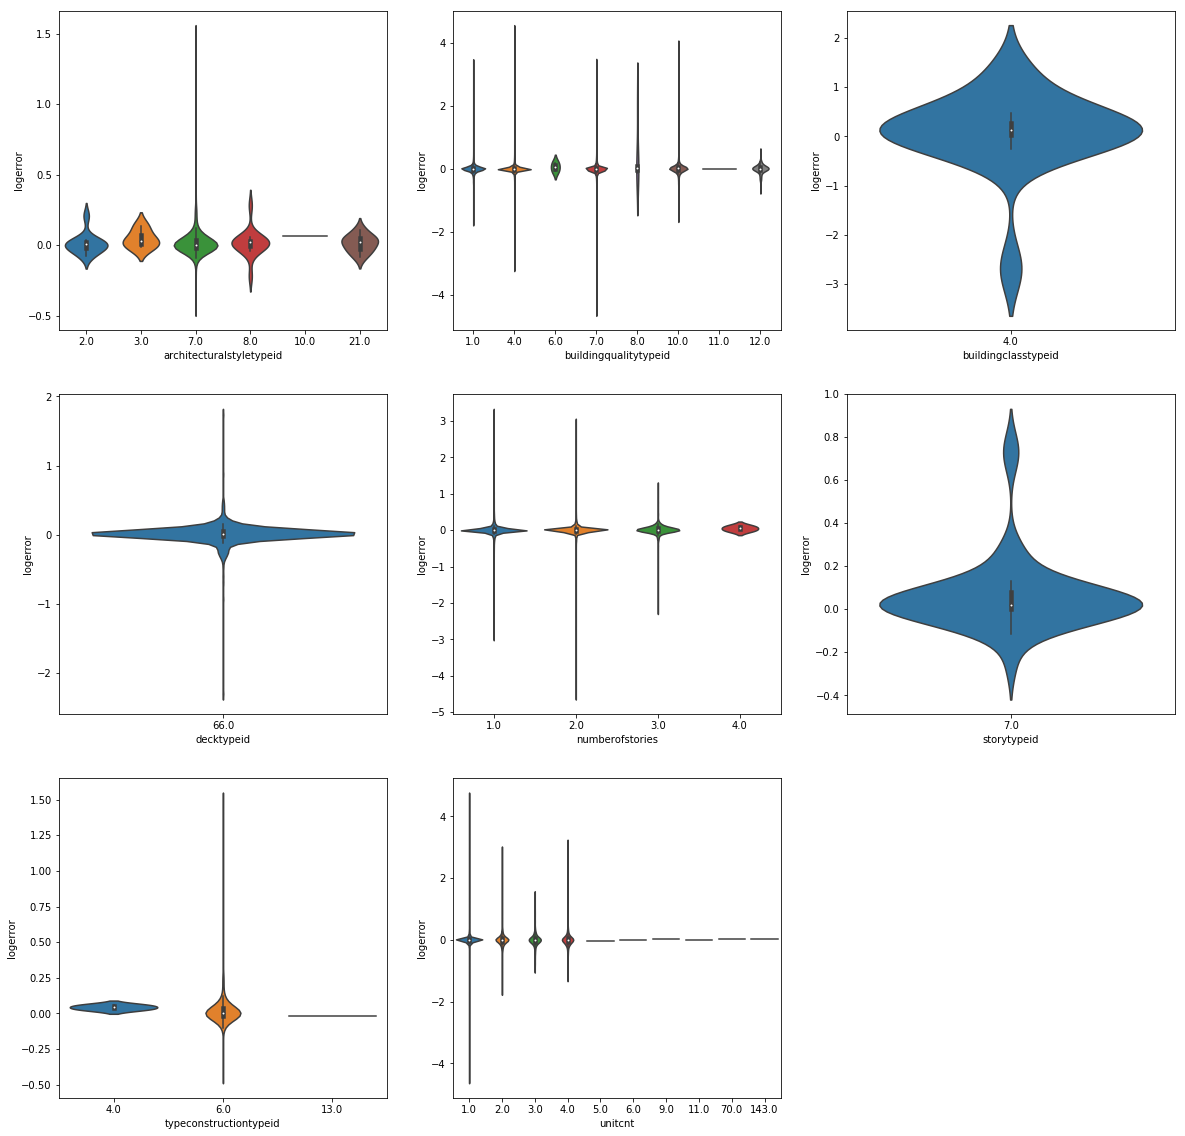

In [51]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_outer_col):
    plt.subplot(3,3,idx+1)
    sns.violinplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- discrete data 에 대해서 plot을 그려보니, 카테고리 자체가 1개인 컬럼이 존재한다는 것과 multiple(2개 이상)한 카테고리를 가지고 있지만, 그 분포가 치우쳐져있는 컬럼이 있다는 것을 파악할 수 있다.
- 이와 같은 특성은 곧 실시한 data cleaning에서 감안해야 할 부분이다.

## 1.3.3) Individual columns' feature analysis -- Region-feature

### scatter plot about numerical data

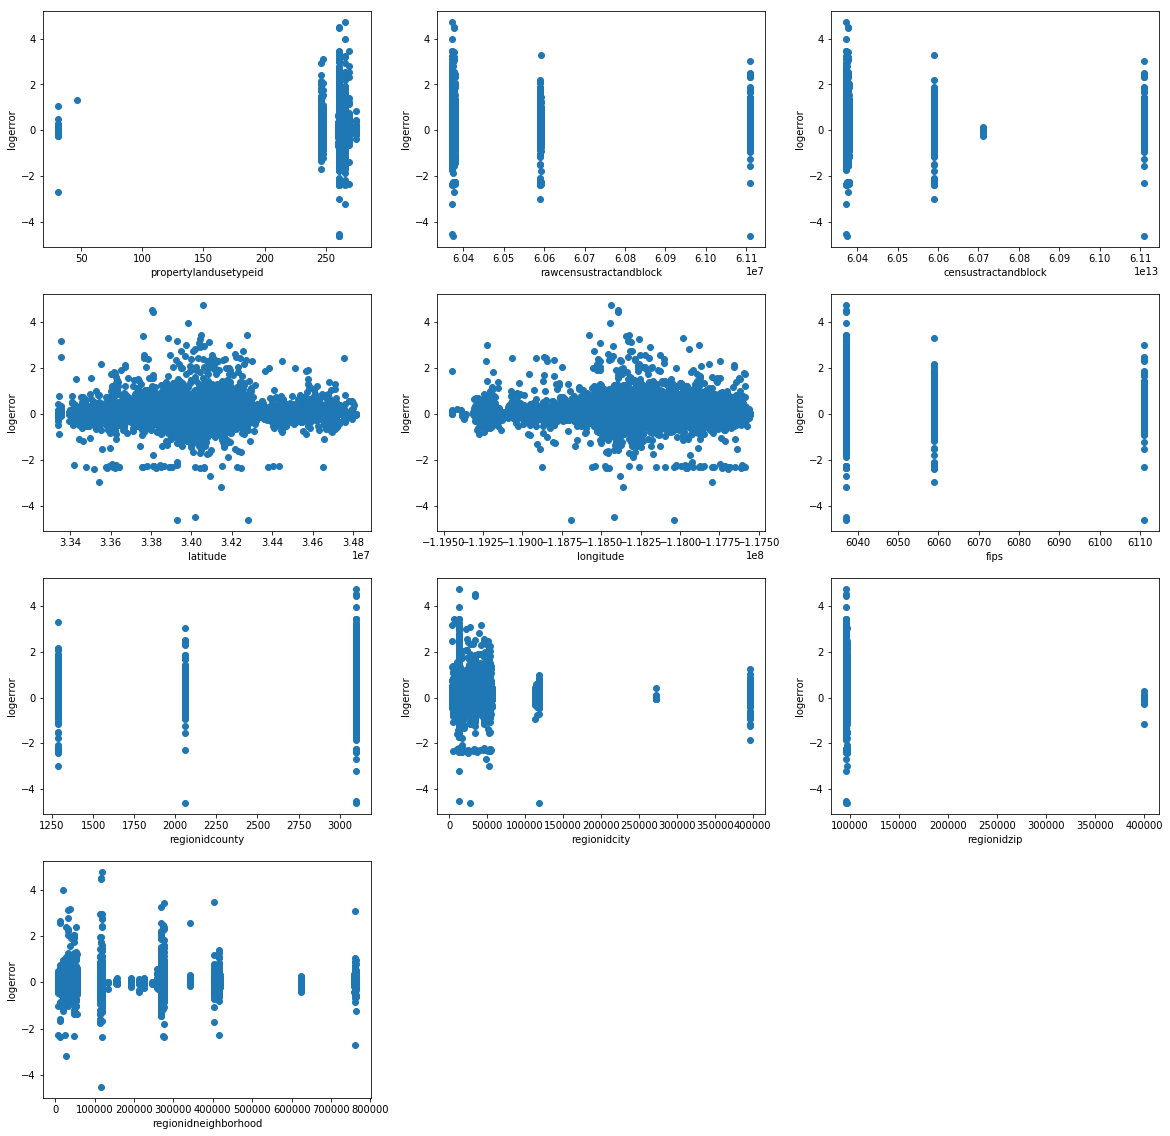

In [54]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(region_numeric):
    plt.subplot(4,3,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- float 자료형에 대한 scatterplot을 그려본 결과 분포의 형태가 continuous하지 않고, discrete한 분포를 띄고 있다.
- 즉, numeric category를 가지고 있을 수 있는 컬럼이라고 생각하고, 카테고리의 갯수를 20개 미만으로 가지는 데이터에 대해서 다시 분포에 대해 시각화해본다.

In [55]:
discrete_region_col = []
for idx,col in enumerate(region_feature_col):
    if len(train_df[col].value_counts())<40:
        discrete_region_col.append(col)
len(discrete_region_col)

3

#### 40 개 미만의 카테고리를 가지는 discrete data column 이 총 3개가 나왔다. 이 컬럼들에 대해서 stripplot,viloinplot을 적용해 시각화한다.

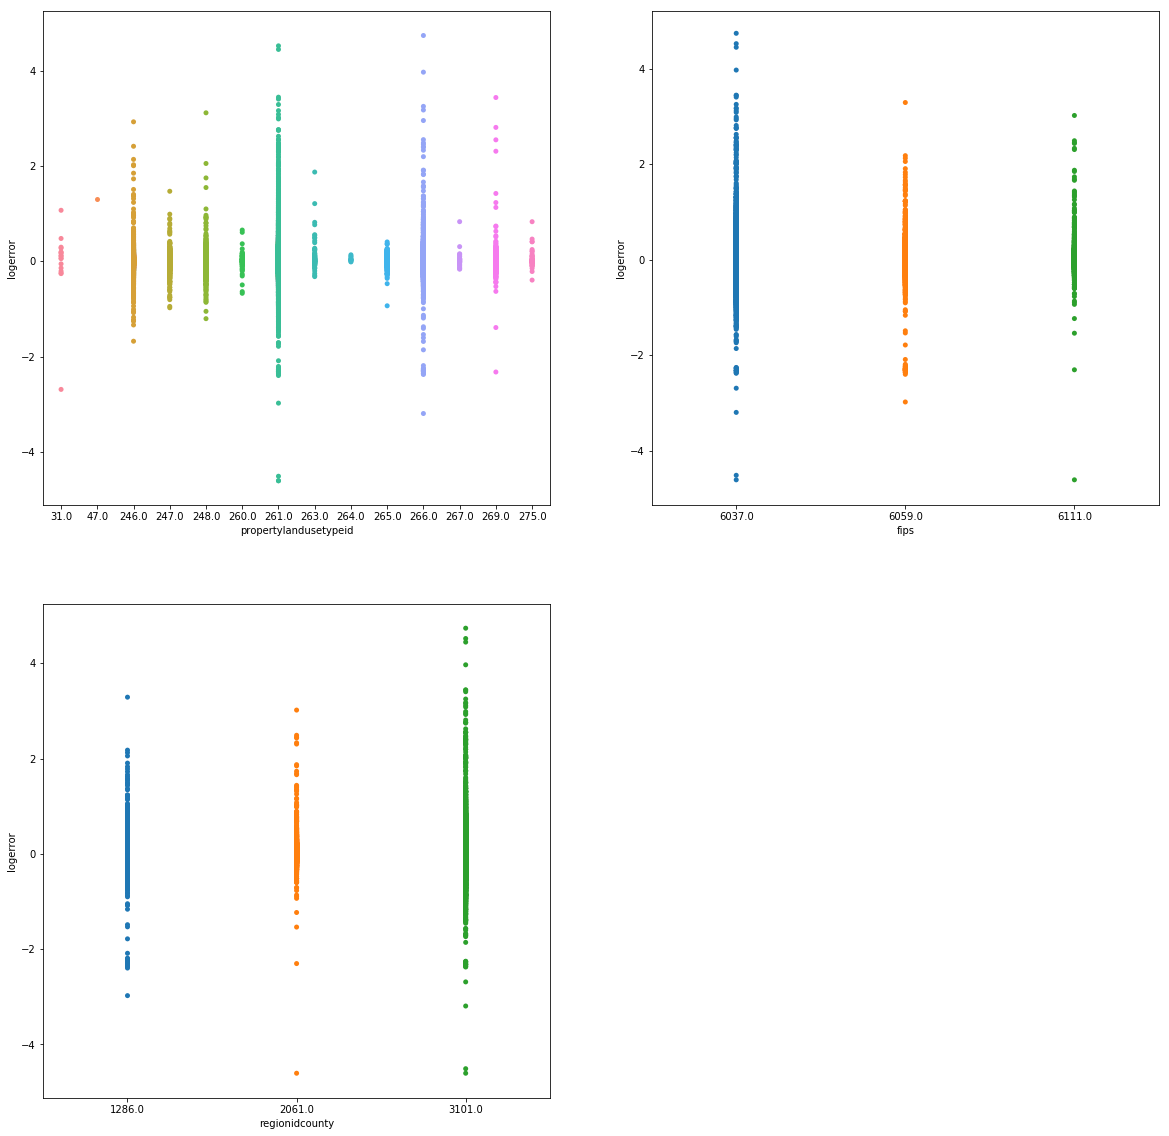

In [56]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_region_col):
    plt.subplot(2,2,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

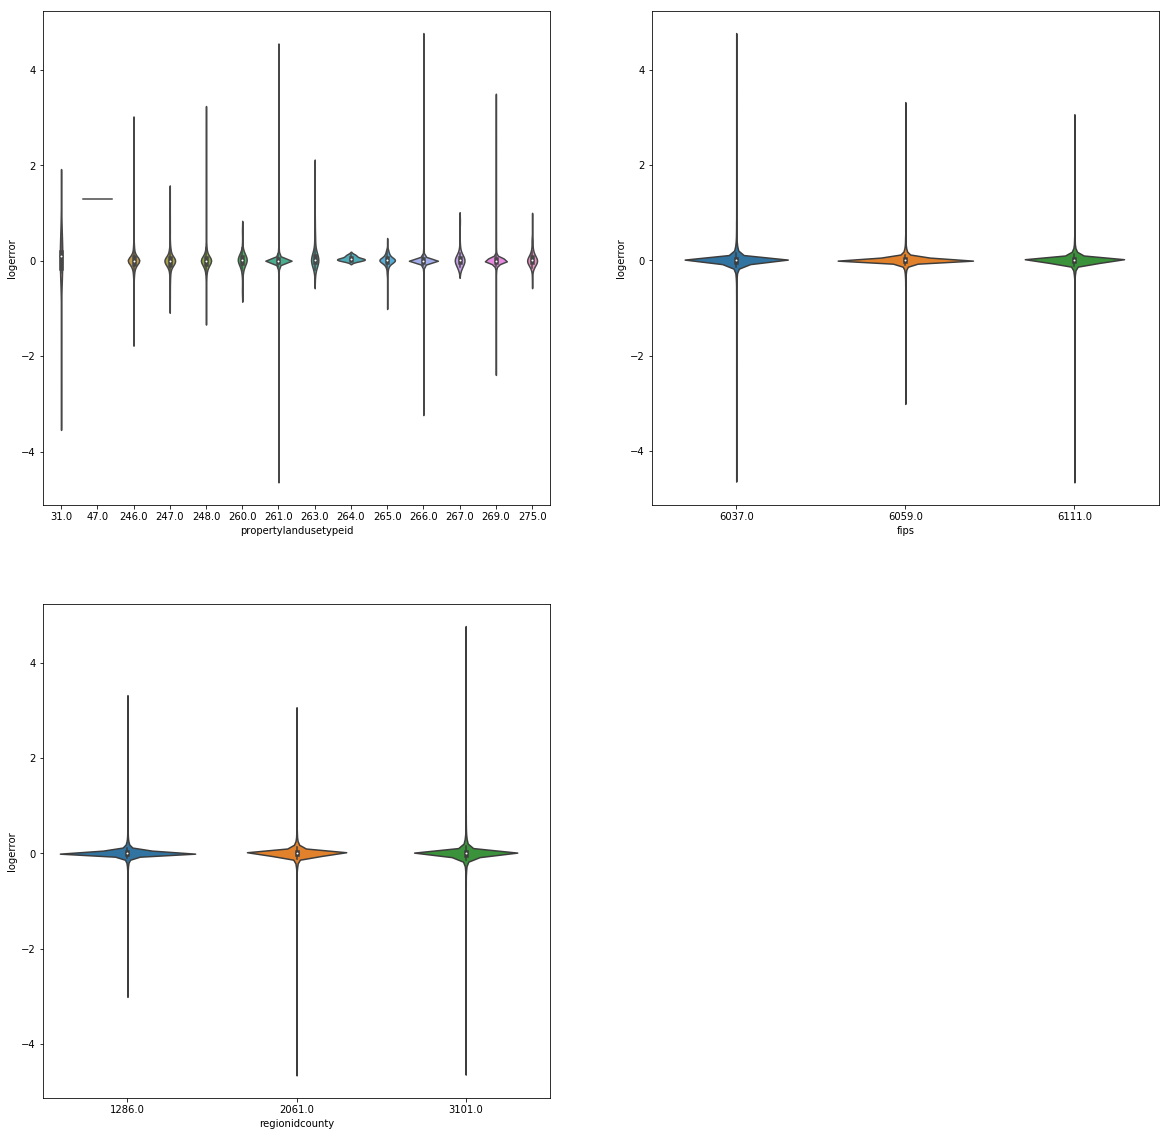

In [57]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_region_col):
    plt.subplot(2,2,idx+1)
    sns.violinplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

## 1.3.4) Individual columns' feature analysis -- Tax-feature

### scatter plot about numerical data

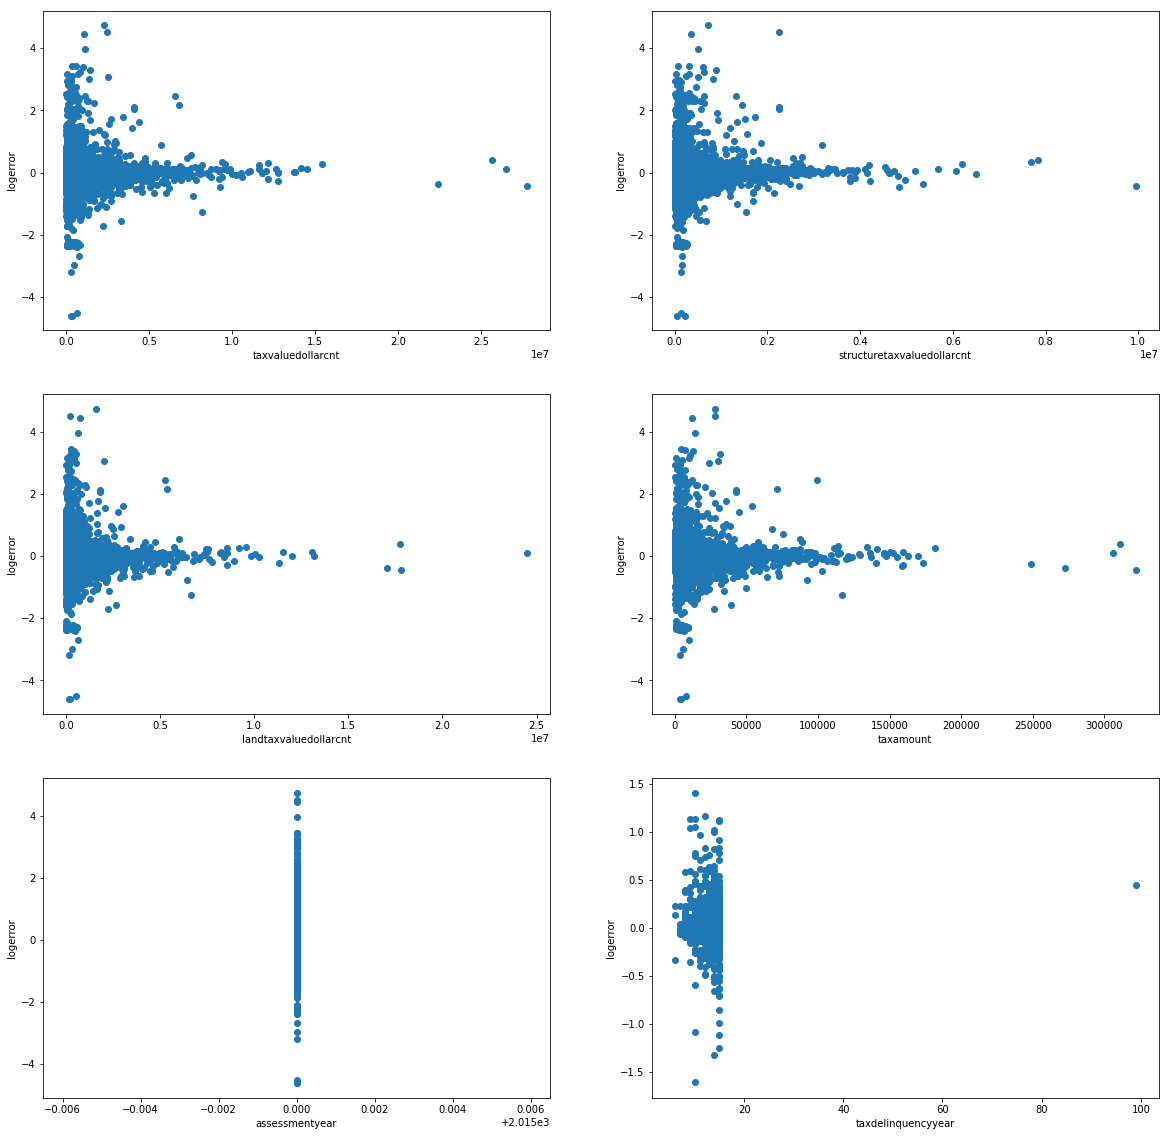

In [58]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(tax_numeric):
    plt.subplot(3,2,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- float 자료형에 대한 scatterplot을 그려본 결과 분포의 형태가 continuous하지 않고, discrete한 분포를 띄고 있다.
- 즉, numeric category를 가지고 있을 수 있는 컬럼이라고 생각하고, 카테고리의 갯수를 40개 미만으로 가지는 데이터에 대해서 다시 분포에 대해 시각화해본다.

In [59]:
discrete_tax_col = []
for idx,col in enumerate(tax_numeric):
    if len(train_df[col].value_counts())<40:
        discrete_tax_col.append(col)
len(discrete_tax_col)

2

#### 40 개 미만의 카테고리를 가지는 discrete data column 이 총 2개가 나왔다. 이 컬럼들에 대해서 stripplot,viloinplot을 적용해 시각화한다.

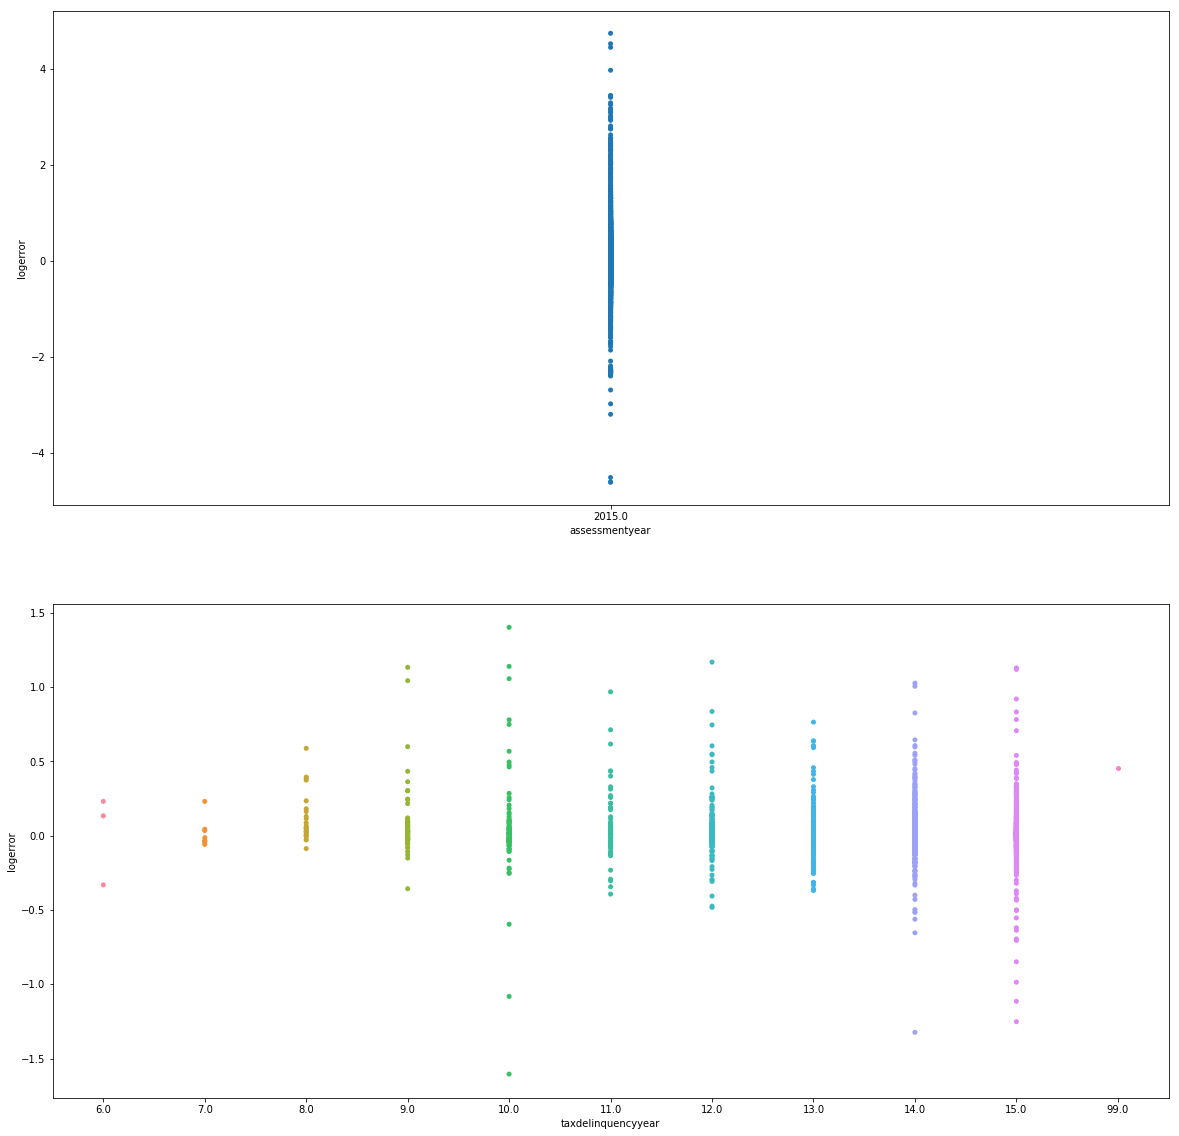

In [60]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_tax_col):
    plt.subplot(2,1,idx+1)
    sns.stripplot(train_df[col],train_df.logerror,data=train_df)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show(col)

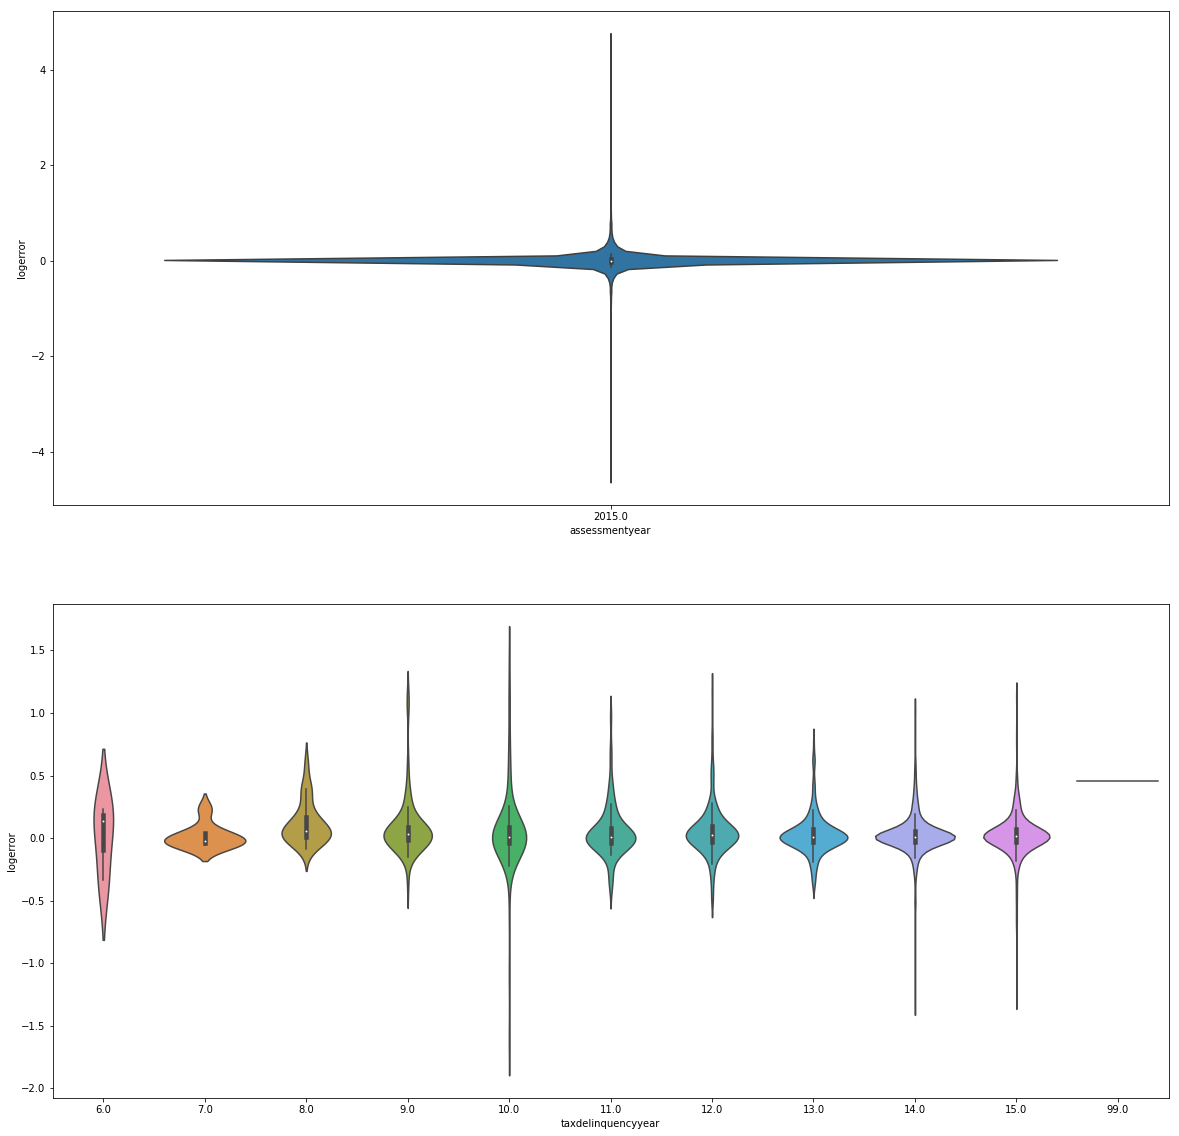

In [61]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_tax_col):
    plt.subplot(2,1,idx+1)
    sns.violinplot(train_df[col],train_df.logerror,data=train_df)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show(col)

- assessmentyear 는 2015년 카테고리 하나를 가지고 있다.
- taxdelinquencyyear column는 고르게 분포되어있으며 카테고리도 다양한 편이다.

#### 마지막으로, object datatype을 가지는 컬럼 1개에 대해서도 countplot으로 시각화를 한다.

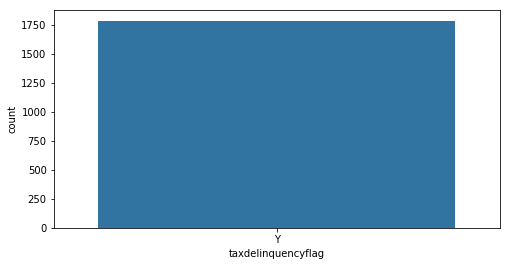

In [62]:
plt.figure(figsize=(8,4))
for idx,col in enumerate(tax_object):
    sns.countplot(train_df[col],data=train_df)
    plt.xlabel(col)
    plt.ylabel('count')
plt.show()

- object datatype의 카테고리는 y하나이다. 
- data cleaning 때 고려할 사항이다.

## 1.3.5) Individual columns' feature analysis -- Sqft-feature

### scatter plot about numerical data

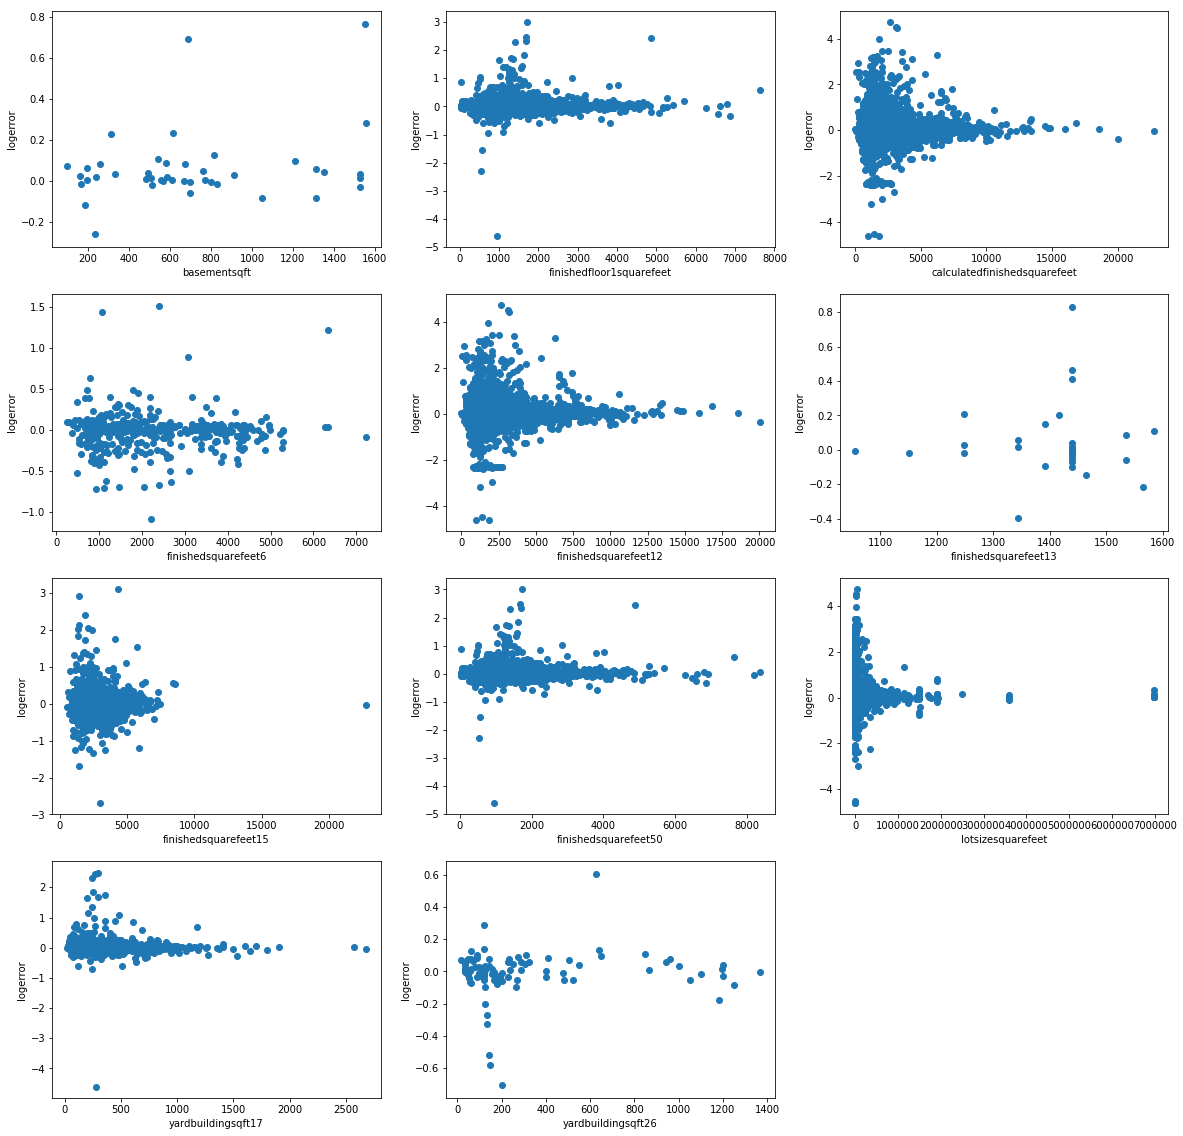

In [63]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(sqrt_feature_col):
    plt.subplot(4,3,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

#### 위의 플롯에서 numeric category를 가지고 있을 수 있는 컬럼이 있다고 가정, 카테고리의 갯수를 40개 미만으로 가지는 데이터에 대해서 다시 분포에 대해 시각화해본다.

In [64]:
discrete_sqrt_col = []
for idx,col in enumerate(sqrt_feature_col):
    if len(train_df[col].value_counts())<40:
        discrete_sqrt_col.append(col)
len(discrete_sqrt_col)

2

- 40 개 미만의 카테고리를 가지는 discrete data column 이 총 2개가 나왔다. 40개 미만의 카테고리값이 주어지긴 했지만 데이터를 자세히 보면 discrete data가 아닌 그냥 data 수가 많지 않은 즉, missing_value가 많은 컬럼임을 알 수 있다.

#### 이 컬럼들에 대해서 stripplot,viloinplot을 적용해 시각화한다.

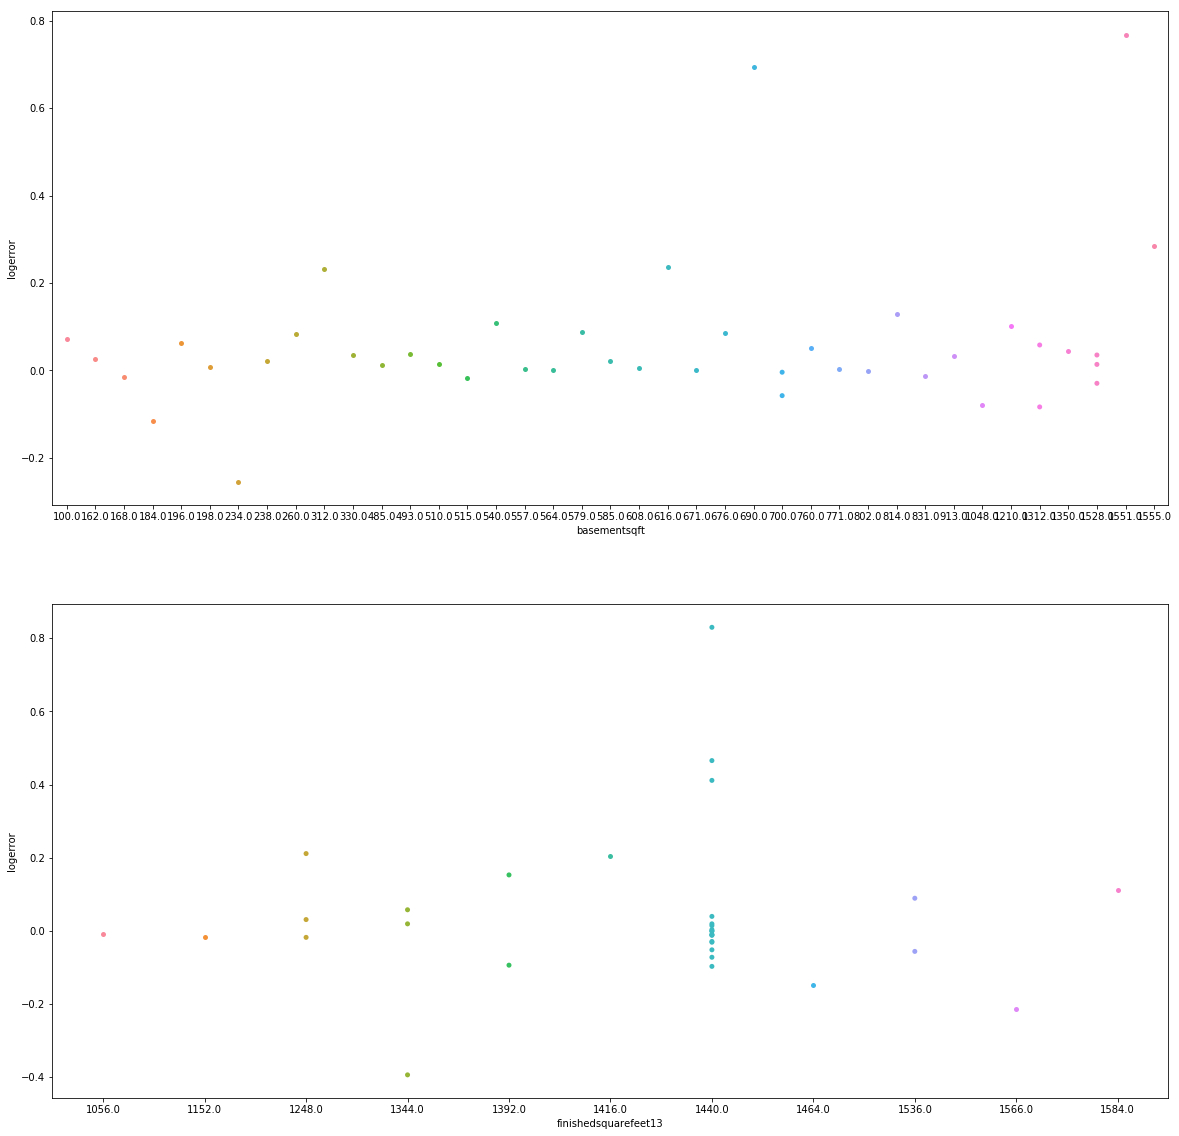

In [65]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_sqrt_col):
    plt.subplot(2,1,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

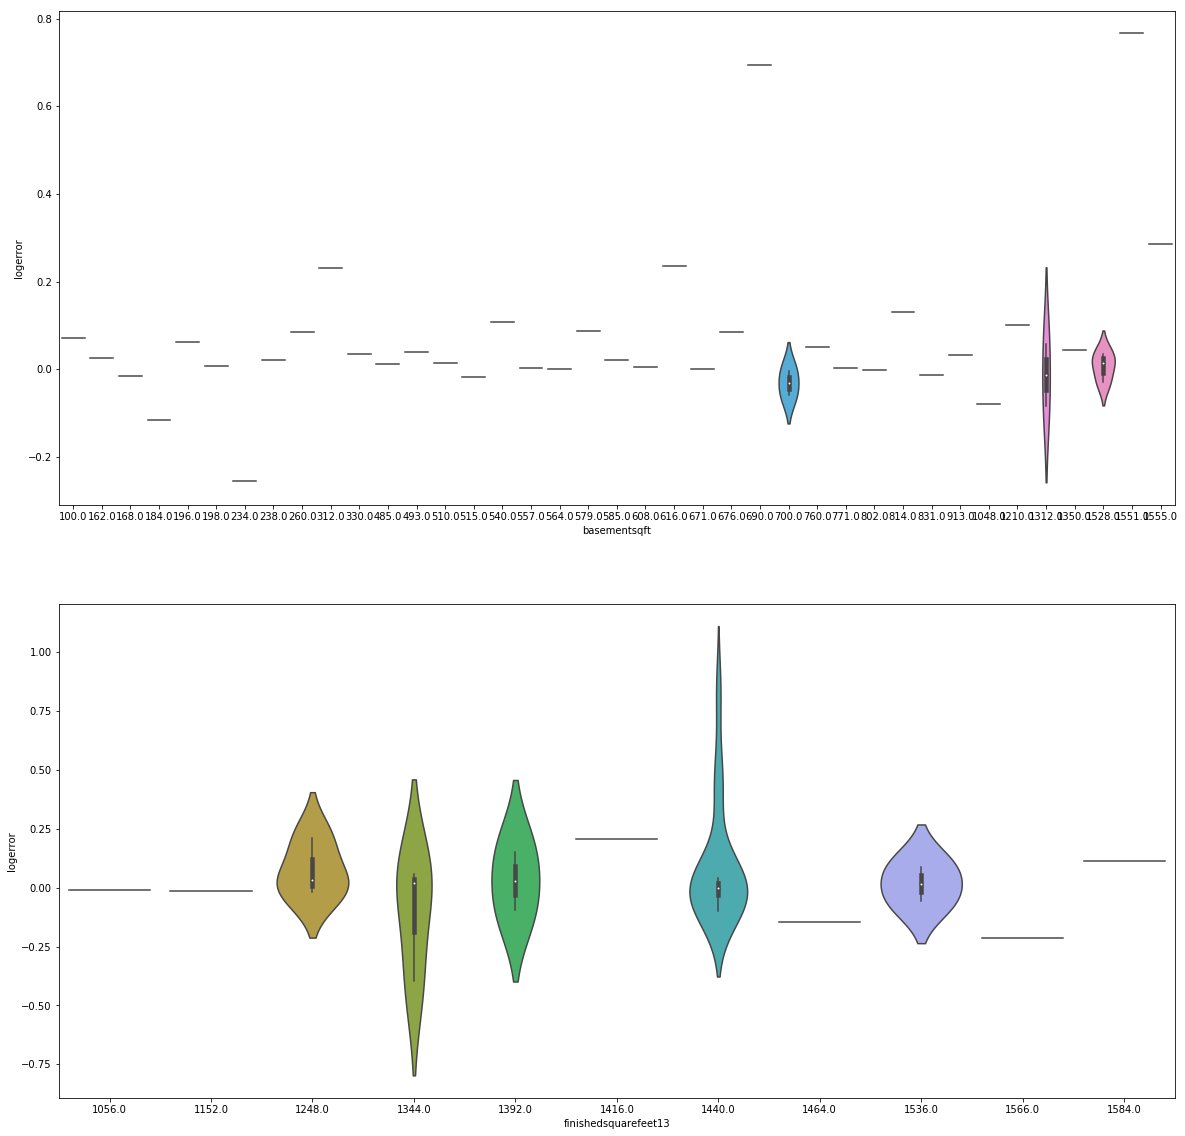

In [66]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_sqrt_col):
    plt.subplot(2,1,idx+1)
    sns.violinplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

# 2.1) Analysis Missing value - Inner-feature 

#### 우선 inner-feature 내의 컬럼들로 구성된 데이터 프레임 'inner_df'를 생성해보겠습니다.

In [67]:
inner_df = train_df[inner_feature_col]
inner_df.tail()

,airconditioningtypeid,bathroomcnt,calculatedbathnbr,threequarterbathnbr,fullbathcnt,bedroomcnt,roomcnt,garagecarcnt,garagetotalsqft,airconditioningtypeid,fireplacecnt,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7
90270,1.0,1.0,1.0,NaN,1.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0
90271,NaN,3.0,3.0,NaN,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
90272,NaN,2.0,2.0,NaN,2.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90273,NaN,2.0,2.0,NaN,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
90274,NaN,1.0,1.0,NaN,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN


In [68]:
missing_inner_df = inner_df.isnull().sum().reset_index()
missing_inner_df.columns = ['col','missing_cnt']
missing_inner_df['missing_ratio'] = missing_inner_df.missing_cnt / len(inner_df)
missing_inner_df.sort_values(by='missing_ratio',inplace=True)
missing_inner_df.reset_index(inplace=True)
missing_inner_df

,index,col,missing_cnt,missing_ratio
0,1,bathroomcnt,0,0.000000
1,5,bedroomcnt,0,0.000000
2,6,roomcnt,0,0.000000
3,2,calculatedbathnbr,1182,0.013093
4,4,fullbathcnt,1182,0.013093
5,13,heatingorsystemtypeid,34195,0.378787
6,7,garagecarcnt,60338,0.668380
7,8,garagetotalsqft,60338,0.668380
8,0,airconditioningtypeid,61494,0.681185
9,9,airconditioningtypeid,61494,0.681185


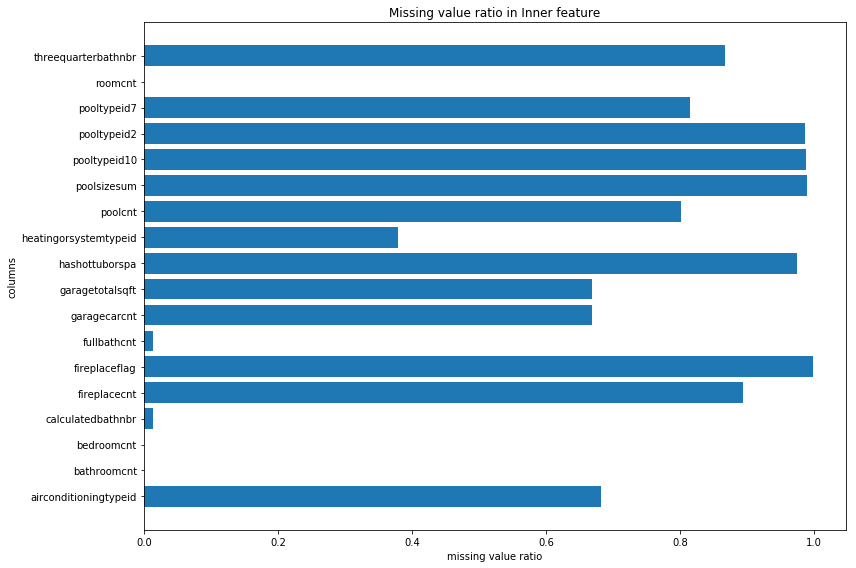

In [69]:
plt.figure(figsize=(12,8))
plt.barh(missing_inner_df.col,missing_inner_df.missing_ratio)
plt.title('Missing value ratio in Inner feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.1.1) Fill the Missing data - Inner-feature

In [70]:
missing_inner_df

,index,col,missing_cnt,missing_ratio
0,1,bathroomcnt,0,0.000000
1,5,bedroomcnt,0,0.000000
2,6,roomcnt,0,0.000000
3,2,calculatedbathnbr,1182,0.013093
4,4,fullbathcnt,1182,0.013093
5,13,heatingorsystemtypeid,34195,0.378787
6,7,garagecarcnt,60338,0.668380
7,8,garagetotalsqft,60338,0.668380
8,0,airconditioningtypeid,61494,0.681185
9,9,airconditioningtypeid,61494,0.681185


- 위의 missing_ratio를 보면 5개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data , categorical data
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

#### bathroomcnt : 0.0%
- Description: 화장실 갯수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 집별로 화장실 갯수는 2개가 일반적(most common)임을 알 수 있다.

#### bedroomcnt	 : 0.0%
- Description: 침실 갯수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 집별로 침실 갯수는 3개가 일반적(most common)임을 알 수 있다.

#### roomcnt	 : 0.0%
- Description: 주거지에있는 총 객실 수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 위의 다른 컬럼들과는 달리 0값이 많이 나오고 그 다음이 6개의 객실이 많이 나온다. 즉슨, 객실을 가지고 있지 않은 집이 일반적이며 객실이 있는 집들은 그 갯수가 많은 경향성을 띄고 있다고 해석할 수 있다. 집 값에 영향을 미칠 수 있다고 생각한다.

#### calculatedbathnbr	 : 1.3%
- Description: 화장실 갯수
- Process: 해당 데이터는 위의 bathroomcnt와 같은 것을 의미하는 컬럼이다. 이 컬럼에 대해서 mode로 missing_value을 채워준다.

In [71]:
train_df.calculatedbathnbr = train_df.calculatedbathnbr.fillna(train_df.calculatedbathnbr.mode()[0])

#### fullbathcnt	 : 1.3%
- Description: 풀옵션 화장실의 갯수
- Process: 위의 bathroomcnt column과 샘플 측면에서 어떤 것들이 다르게 드러나는지 비교해서 확인해보겠다.

In [72]:
train_df.fullbathcnt = train_df.fullbathcnt.fillna(train_df.fullbathcnt.mode()[0])

#### heatingorsystemtypeid	 : 37.8%
- Description: 난방 시스템의 타입
- Process: describe method, count_value method를 통해 본결과 난방 시스템은 'Central'이라는 시스템이 가장 일반적으로(most common) 많이 사용되기 때문에, missing_value에 mode값을 넣어준다.

In [73]:
train_df.heatingorsystemtypeid = train_df.heatingorsystemtypeid.fillna(train_df.heatingorsystemtypeid.mode()[0])

In [74]:
train_df.heatingorsystemtypeid = train_df.heatingorsystemtypeid.astype('object')

#### garagecarcnt : 66.83%
- Description: 차고 갯수
- Process: discrete data로써 2개의 차고를 가지고 있는 집들이 가장 많기 때문에 (usual) mode값으로 filling_NaN 을 해준다.

In [75]:
train_df.garagecarcnt = train_df.garagecarcnt.fillna(train_df.garagecarcnt.mode()[0])

#### garagetotalsqft : 66.83%
- Description: 차고 평방(크기)
- Process: 차고 갯수를 나타내는 컬럼과 크기를 나타내는 컬럼의 missing_value 크기가 같다. zillow측에서 조사할 때 쌍으로 같이 조사한 것으로 보인다. 또한, values의 수가 70이며 sqft(volume)을 측정한 것으로 continuous data이다. 또한, min 값이 0이며 하위 25%까지 0값이 있는 것으로 보아 차고가 없으면 0이라고 따로 기제를 한 것이다. 이에 따라 missing_value에는 mean값으로 채워준다.

In [76]:
train_df.garagetotalsqft = train_df.garagetotalsqft.fillna(np.mean(train_df.garagetotalsqft))

#### airconditioningtypeid : 68.16%
- Description: 에이컨 아이디
- Process: 통계치를 보게 되면, 압도적으로 1번 항목인, 'Central'이 많다. 이에 따라 missing_value에 mode값인 1을 취해준다.

In [77]:
train_df.airconditioningtypeid = train_df.airconditioningtypeid.fillna(train_df.airconditioningtypeid.mode()[0])

In [78]:
train_df.airconditioningtypeid = train_df.airconditioningtypeid.astype('object')

#### poolcnt : 80.17%
- Description: 수영장 갯수
- Process: 통계치에서 1만 있는 데이터가 나온다. 여기서 없는 데이터는 수영장이 없는 집이라고 생각할 수 있다. 따라서 missing_value에는 0을 넣는다.

In [79]:
train_df.poolcnt = train_df.poolcnt.fillna(0)

In [80]:
train_df.poolcnt = train_df.poolcnt.astype('object')

#### pooltypeid7 : 81.50%
- Description: 온수 욕조가없는 수영장
- Process: 통계치에서 1만 있는 데이터가 나온다. 여기서 없는 데이터는 온수욕조가 없는 집이라고 생각할 수 있다. 따라서 missing_value에는 0을 넣는다.

In [81]:
train_df.pooltypeid7 = train_df.pooltypeid7.fillna(0)

In [82]:
train_df.pooltypeid7 = train_df.pooltypeid7.astype('object')

#### threequarterbathnbr : 86.69%
- Description:집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
- Process: 샤워,세면대,화장실을 모두 가지고 있는 욕실을 의미하는 것으로 없는 값은 이를 충족하지 못하는 집이라고 간주, 0을 채워준다.a

In [83]:
train_df.threequarterbathnbr = train_df.threequarterbathnbr.fillna(0)

#### hashottuborspa :97.38%
- Description:난방 시스템의 유무
- Process: 해당 컬럼은 True or False 형태의 dtype:Object 인 컬럼이다. NaN 값에 False를 넣어준다.

In [84]:
train_df.hashottuborspa  = train_df.hashottuborspa .fillna('False')

#### fireplacecnt :89.35%
- Description:벽난로 수
- Process: 해당 컬럼의 value을 살펴보면 1-5까지가 있다. 즉 missing_value의 의미는 벽난로가 없는 집을 의미한다. NaN -> 0

In [85]:
train_df.fireplacecnt  = train_df.fireplacecnt .fillna(0)

####  pooltypeid2 :  98.66%
- Description: 스파 / 온수 욕조가있는 수영장
- Process: 있다 없다로 나타내기 위해서 1이라는 데이터만 있는 상태이다. 없는 NaN값에 0을 넣어준다.

In [86]:
train_df.pooltypeid2  = train_df.pooltypeid2 .fillna(0)

In [87]:
train_df.pooltypeid2 = train_df.pooltypeid2.astype('object')

#### pooltypeid10 : 98.71%
- Description:   온수 욕조가없는 수영장
- Process: 있다 없다로 나타내기 위해서 1이라는 데이터만 있는 상태이다. 없는 NaN값에 0을 넣어준다.

In [88]:
train_df.pooltypeid10  = train_df.pooltypeid10 .fillna(0)

In [89]:
train_df.pooltypeid10 = train_df.pooltypeid10.astype('object')

#### poolsizesum : 98.92%
- Description:  수영장 크기
- Process: value_counts결과값이 매우 다양하다. 없는 데이터는 NaN 에 0을 넣으므로써 수영장이 없는 집임을 나타낼 수 있다. missing_value에 0으로 채운다.

In [90]:
train_df.poolsizesum  = train_df.poolsizesum .fillna(0)

#### fireplaceflag : 99.75%
- Description:  벽난로가 있는지 없는지
- Process: True or False 로 나뉘어져 있는 데이터이며, False를 나타내는 데이터가 누락된 것으로 보인다. missing_value를 'False'로 채워준다.

In [91]:
train_df.fireplaceflag  = train_df.fireplaceflag .fillna('False')

# 2.2) Analysis Missing value - Outer-feature 

#### 우선 outer-feature 내의 컬럼들로 구성된 데이터 프레임 'outer_df'를 생성해보겠습니다.

In [92]:
outer_df = train_df[outer_feature_col]
outer_df.tail()

,architecturalstyletypeid,buildingqualitytypeid,buildingclasstypeid,decktypeid,numberofstories,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt
90270,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1979.0
90271,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1965.0
90272,NaN,7.0,NaN,NaN,NaN,NaN,NaN,2.0,1924.0
90273,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1981.0
90274,NaN,7.0,NaN,NaN,NaN,NaN,NaN,1.0,1947.0


In [93]:
outer_df.describe()

,architecturalstyletypeid,buildingqualitytypeid,buildingclasstypeid,decktypeid,numberofstories,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt
count,261.000000,57364.000000,16.0,658.0,20570.000000,43.0,299.000000,58353.000000,89519.000000
mean,7.229885,5.565407,4.0,66.0,1.440739,7.0,6.010033,1.110414,1968.532870
std,2.716196,1.900602,0.0,0.0,0.544498,0.0,0.437235,0.797235,23.763475
min,2.000000,1.000000,4.0,66.0,1.000000,7.0,4.000000,1.000000,1885.000000
25%,7.000000,4.000000,4.0,66.0,1.000000,7.0,6.000000,1.000000,1953.000000
50%,7.000000,7.000000,4.0,66.0,1.000000,7.0,6.000000,1.000000,1970.000000
75%,7.000000,7.000000,4.0,66.0,2.000000,7.0,6.000000,1.000000,1987.000000
max,21.000000,12.000000,4.0,66.0,4.000000,7.0,13.000000,143.000000,2015.000000


In [94]:
missing_outer_df = outer_df.isnull().sum().reset_index()
missing_outer_df.columns = ['col','missing_cnt']
missing_outer_df['missing_ratio'] = missing_outer_df.missing_cnt / len(outer_df)
missing_outer_df.sort_values(by='missing_ratio',inplace=True)
missing_outer_df.reset_index(drop=True,inplace=True)
missing_outer_df

,col,missing_cnt,missing_ratio
0,yearbuilt,756,0.008374
1,unitcnt,31922,0.353608
2,buildingqualitytypeid,32911,0.364564
3,numberofstories,69705,0.772141
4,decktypeid,89617,0.992711
5,typeconstructiontypeid,89976,0.996688
6,architecturalstyletypeid,90014,0.997109
7,storytypeid,90232,0.999524
8,buildingclasstypeid,90259,0.999823


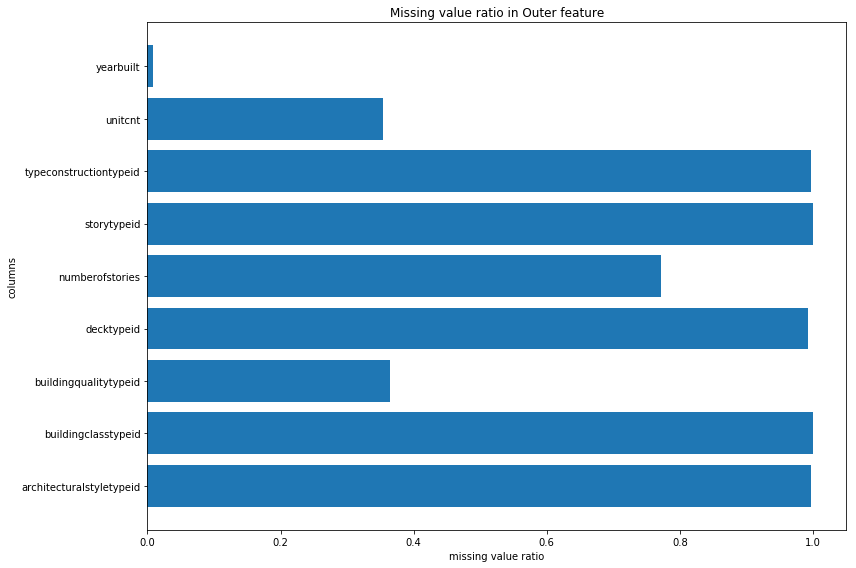

In [95]:
plt.figure(figsize=(12,8))
plt.barh(missing_outer_df.col,missing_outer_df.missing_ratio)
plt.title('Missing value ratio in Outer feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.2.1) Fill the Missing data - Outer-feature

In [96]:
missing_outer_df

,col,missing_cnt,missing_ratio
0,yearbuilt,756,0.008374
1,unitcnt,31922,0.353608
2,buildingqualitytypeid,32911,0.364564
3,numberofstories,69705,0.772141
4,decktypeid,89617,0.992711
5,typeconstructiontypeid,89976,0.996688
6,architecturalstyletypeid,90014,0.997109
7,storytypeid,90232,0.999524
8,buildingclasstypeid,90259,0.999823


- 위의 missing_ratio를 보면 6개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data(categorical)
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

#### yearbuilt : 0.8%
- Description:  주거지가 지어진 해
- Process: 카테고리가 130개로 매우 많지만, 년도를 나타내는 discrete data이기 때문에, mode 값으로 fill the miss한다.

In [97]:
train_df.yearbuilt = train_df.yearbuilt.fillna(train_df.yearbuilt.mode()[0])

#### unitcnt 35%
- Description: 구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)
- Process: 1중 구조가 가장 많으므로 이러한 구조가 일반적(common)인 것임을 알 수 있다.

In [98]:
train_df.unitcnt = train_df.unitcnt.fillna(train_df.unitcnt.mode()[0])

#### buildingqualitytypeid : 36%
- Description: 건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)
- Process: 7점이 가장 많지만, 상태에 대한 평가이기 때문에, 평균값인 5점으로 filling 한다.

In [99]:
train_df.buildingqualitytypeid = train_df.buildingqualitytypeid.fillna(train_df.buildingqualitytypeid.mean())

#### numberofstories 77.2%
- Description: 집의 층 수 (story or level이라고 표현한다.)
- Process: 집의 층 수가 몇 개인지에 대한 컬럼이다. 주로 1층과 2층집이 많은 것을 감안해 mode값을 넣어준다.

In [100]:
train_df.numberofstories = train_df.numberofstories.fillna(train_df.numberofstories.mode()[0])

#### typeconstructiontypeid 99.6%
- Description: census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함
- Process: typeID에는 0번이 없다(1~18). 가지고 있는 데이터가 대표성을 지니고 있지 않으므로 None을 채워준다.

In [101]:
train_df.typeconstructiontypeid = train_df.typeconstructiontypeid.fillna('None')

In [102]:
train_df.typeconstructiontypeid = train_df.typeconstructiontypeid.astype('object')

#### architecturalstyletypeid 99.7%
- Description: 건축 양식 아이디
- Process: 위의 컬럼과 마찬가지로 0번 ID는 존재하지 않는다. (1~27) 7번 ID가 가장많지만 missing_value가 너무 많아, 대표성을 지니지 못한다. None 값을 채워준다.

In [103]:
train_df.architecturalstyletypeid = train_df.architecturalstyletypeid.fillna('None')

In [104]:
train_df.architecturalstyletypeid = train_df.architecturalstyletypeid.astype('object')

#### storytypeid
- Description: 집의 층 수 (story or level이라고 표현한다.)
- Process: 집의 층수를 나타내는 컬럼인데, 7의 데이터밖에 없어 대표성을 가지지 못한다. None값으로 채워준다.

In [105]:
train_df.storytypeid = train_df.storytypeid.fillna('None')

In [106]:
train_df.storytypeid = train_df.storytypeid.astype('object')

#### buildingclasstypeid
- Description: 건물 뼈대에 어떤 타입의 재료가 쓰였는지
- Process: TypeID는 건물 뼈대에 따라 1~5의 ID를 가지는데 4를 최빈값으로 가지지만, 대표성을 지니지 못한다.None으로 채워준다.

In [107]:
train_df.buildingclasstypeid = train_df.buildingclasstypeid.fillna('None')

In [108]:
train_df.buildingclasstypeid = train_df.buildingclasstypeid.astype('object')

#### decktypeID : 89.61%
- Description: 집 마당 부근에 있는 갑판(테라스와 유사)
- Process: 컬럼의 이름에서 명시하다시피 typeID에 관한 컬럼이다. 66 typeID가 최빈값으로 존재하지만, 대표성을 가지지 못한다. None으로 채워준다.

In [109]:
train_df.decktypeid = train_df.decktypeid.fillna('None')

In [110]:
train_df.decktypeid = train_df.decktypeid.astype('object')

# 2.3) Analysis Missing value - Region-feature

#### Region-feature 내의 컬럼들로 구성된 데이터 프레임 'region_df'를 생성해보겠습니다.

In [111]:
region_df = train_df[region_feature_col]
region_df.tail()

,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,censustractandblock,latitude,longitude,fips,regionidcounty,regionidcity,regionidzip,regionidneighborhood
90270,010C,266.0,LARD1.5,6.037132e+07,6.037132e+13,34203000.0,-118562000.0,6037.0,3101.0,12447.0,96364.0,40548.0
90271,0100,261.0,GLR1RY,6.037301e+07,6.037301e+13,34198744.0,-118224849.0,6037.0,3101.0,45457.0,96327.0,274580.0
90272,0200,246.0,EMR3YY,6.037433e+07,6.037433e+13,34075655.0,-118025537.0,6037.0,3101.0,51861.0,96478.0,NaN
90273,010C,266.0,INR4*,6.037601e+07,6.037601e+13,33963900.0,-118367000.0,6037.0,3101.0,45888.0,96133.0,NaN
90274,0100,261.0,CARS*,6.037544e+07,6.037544e+13,33838933.0,-118219093.0,6037.0,3101.0,NaN,96244.0,NaN


In [112]:
missing_region_df = region_df.isnull().sum().reset_index()
missing_region_df.columns = ['col','missing_cnt']
missing_region_df['missing_ratio'] = missing_region_df.missing_cnt / len(region_df)
missing_region_df.sort_values(by='missing_ratio',inplace=True)
missing_region_df.reset_index(drop=True,inplace=True)
missing_region_df

,col,missing_cnt,missing_ratio
0,propertylandusetypeid,0,0.000000
1,rawcensustractandblock,0,0.000000
2,latitude,0,0.000000
3,longitude,0,0.000000
4,fips,0,0.000000
5,regionidcounty,0,0.000000
6,propertycountylandusecode,1,0.000011
7,regionidzip,35,0.000388
8,censustractandblock,605,0.006702
9,regionidcity,1803,0.019972


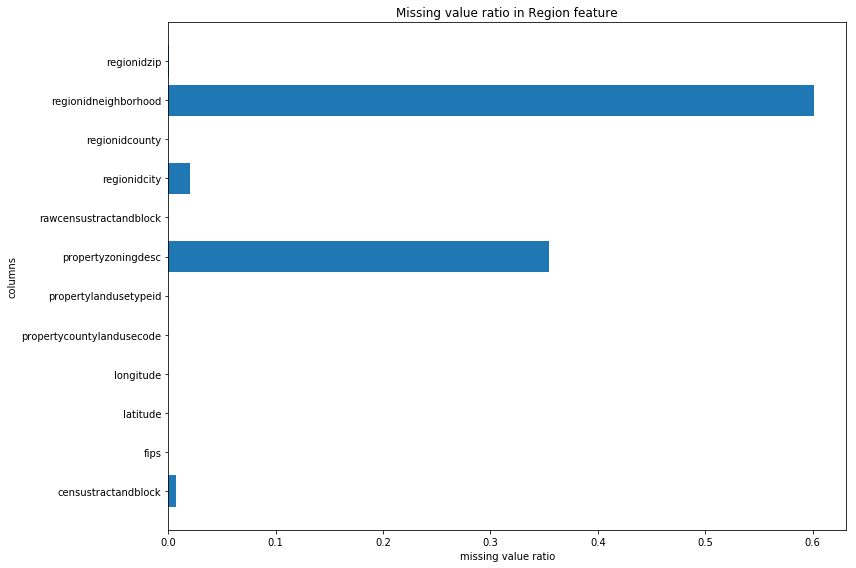

In [113]:
plt.figure(figsize=(12,8))
plt.barh(missing_region_df.col,missing_region_df.missing_ratio)
plt.title('Missing value ratio in Region feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.3.1) Fill the Missing data - Region-feature

In [114]:
missing_region_df

,col,missing_cnt,missing_ratio
0,propertylandusetypeid,0,0.000000
1,rawcensustractandblock,0,0.000000
2,latitude,0,0.000000
3,longitude,0,0.000000
4,fips,0,0.000000
5,regionidcounty,0,0.000000
6,propertycountylandusecode,1,0.000011
7,regionidzip,35,0.000388
8,censustractandblock,605,0.006702
9,regionidcity,1803,0.019972


- 위의 missing_ratio를 보면 5개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data , categorical data
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

In [115]:
region_df.tail()

,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,censustractandblock,latitude,longitude,fips,regionidcounty,regionidcity,regionidzip,regionidneighborhood
90270,010C,266.0,LARD1.5,6.037132e+07,6.037132e+13,34203000.0,-118562000.0,6037.0,3101.0,12447.0,96364.0,40548.0
90271,0100,261.0,GLR1RY,6.037301e+07,6.037301e+13,34198744.0,-118224849.0,6037.0,3101.0,45457.0,96327.0,274580.0
90272,0200,246.0,EMR3YY,6.037433e+07,6.037433e+13,34075655.0,-118025537.0,6037.0,3101.0,51861.0,96478.0,NaN
90273,010C,266.0,INR4*,6.037601e+07,6.037601e+13,33963900.0,-118367000.0,6037.0,3101.0,45888.0,96133.0,NaN
90274,0100,261.0,CARS*,6.037544e+07,6.037544e+13,33838933.0,-118219093.0,6037.0,3101.0,NaN,96244.0,NaN


#### propertycountylandusecode : 0.0%
- Description: 'county land use code : 지역이 어떻게 개발되고 사용되는지에 규제하는 것에 대한 정보가 있는 코드'
- Process: object datatype으로 code 종류는 77개가 있다. missing_value가 1개가 있으므로 mode값으로 채워넣어준다.

In [116]:
train_df.propertycountylandusecode = train_df.propertycountylandusecode.fillna(train_df.propertycountylandusecode.mode()[0])

In [117]:
train_df.propertycountylandusecode = train_df.propertycountylandusecode.astype('object') 

#### propertylandusetypeid : 0.0%
- Description: '토지가 어떻게 사용되는지에 대한 타입'
- Process: missing_value가 없다. 통계치를 살펴보게 되면, 'single family residential' 즉, 단독주택의 비율이 가장 높다. 그 다음으로는 분양 아파트가 높다.

In [118]:
train_df.propertylandusetypeid = train_df.propertylandusetypeid.astype('object') 

#### censustractandblock : 0.67%
- Description: ' Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함

#### rawcensustractandblock : 0.00%
- Description: 'Census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함

#### process 
- 해당 두 컬럼은 코드를 나타내는 것이기 때문에 string타입으로 변환하여 비교한다. 두 컬럼의 str타입을 비교해 보면 rawcensustract에서 '.' 을 없애주면 censustract와 같아지는 것을 알 수 있다. 따라서 코드의 표현 방식은 다르지만, 의미하는 지역특성과 속성은 같다고 판단된다.다만 value_count를 해보면 기제된 코드의 종류가 rawcensustract code가 약 250개 정도 많다. 따라서 missing_value가 없는 rawcensus를 채택하고, censustractandblock column은 `delete`

In [119]:
train_df.drop(columns='censustractandblock',inplace=True)
region_feature_col.remove('censustractandblock')

In [120]:
train_df.rawcensustractandblock = train_df.rawcensustractandblock.astype('object') 

#### longtitude : 0.00%
- Description : 소포 중도 경도에 10e6을 곱한

#### latitude : 0.00%
- Description : 소포 중도 위도에 10e6을 곱한 값

#### Process : 
- 위도를 나타내는 latitude와 경도를 나타내는 longtitude 컬럼 또한 pair하게 묶어서 분석한다.
- 두 컬럼 모두 10e6로 scaling process도 이미 되어 있다.
- missing_value가 없으므로, 별다른 process는 필요하지 않다. 

#### regionidcounty	 : 0.00%
- Description : 해당 부동산이 위치하는 카운티(county:Second-level administrative division)
- Process : missing_value가 없기 때문에 처리해야 할 프로세스는 없지만, 통계치를 보게 되면, 3 가지 값으로 나뉘게 된다. fips에서 처리하는 지역의 county fips code이다. 이를 통해 zillow 에서 조사한 지역이 세 곳이며, 세 지역에 대해서 골고루 조사가 된 것은 아닌 것을 알 수 있다. 또한, 지역이 나뉘므로 이에 따른 logerror와의 상관성을 분석해볼 수 있다.

In [121]:
train_df.regionidcounty = train_df.regionidcounty.astype('object') 

#### fips : 0.00%
- Description : 연방 정보 처리 규정(연방에서 해당 지역을 어떻게 정보 처리하는지에 대한 것)
- Process : missing_value가 없기 때문에 처리해야 할 프로세스는 없지만, 통계치를 보게 되면, 3 가지 값으로 나뉘게 된다. fips에서 처리하는 지역의 county fips code이다. 이를 통해 zillow 에서 조사한 지역이 세 곳이며, 세 지역에 대해서 골고루 조사가 된 것은 아닌 것을 알 수 있다. 또한, 지역이 나뉘므로 이에 따른 logerror와의 상관성을 분석해볼 수 있다.

In [122]:
train_df.fips = train_df.fips.astype('object') 

#### propertycountylandusecode : 0.00%
- Description :county land use code는 어떻게 지역이 개발되고 사용될지에 대한 규제이다.
- Process : missing_value가 없으므로 별다른 process는 필요하지 않다. 겹치는 county land use code 값을 가지는 건물이 있으므로 이는, 근접한 건물들이 많다는 것을 의미한다.

In [123]:
train_df.propertycountylandusecode = train_df.propertycountylandusecode.astype('object') 

#### regionzip : 0.0388%
- Description :  해당 부동산이 위치한 우편 번호
- Process : 통계치를 보게 되면, 도시를 코드로 나타내었다. postal code(우편 번호)로 나타낸 것이다. missing_value는 매우 낮은 수준임으로 mode값으로 NaN 값을 채워준다.

In [124]:
train_df.regionidzip = train_df.regionidzip.fillna(train_df.regionidzip.mode()[0])

In [125]:
train_df.regionidzip = train_df.regionidzip.astype('object') 

#### regionidcity : 1.99%
- Description :  해당 건물이 있는 도시 (있는 경우)
- Process : 통계치를 보게 되면, 도시를 코드로 나타내었다. zip code(우편 번호)로 나타낸 것이다. missing_value는 2%로 낮은 수준임으로 mode값으로 NaN값을 채워준다.

In [126]:
train_df.regionidcity = train_df.regionidcity.fillna(train_df.regionidcity.mode()[0])

In [127]:
train_df.regionidcity = train_df.regionidcity.astype('object') 

### postal code vs zip code
- postal code : 우편물에 부착된 바코드(Barcode)를 의미한다.
- zip code : 일반적인 우편 번호를 의미한다.
- 두 코드 모두 우편번호를 의미하기 때문에, regionidcity , regionidzip 두 컬럼 사이의 상관관계에 주목할 필요가 있다.

#### propertyzoningdesc :35.40%
- Description :  해당 부동산에 대해 허용 된 토지 용도 (구역 설정)에 대한 설명
- Process : Zoning은 지역의 속성(위치,용도)에 따라서 구분해놓은 것으로 이에 따른 description이 담겨 있는 컬럼이다. missing_value는 이에 대한 자료가 누락된 것으로 None값을 채워넣는다.

In [128]:
train_df.propertyzoningdesc = train_df.propertyzoningdesc.fillna('None')

In [129]:
train_df.propertyzoningdesc = train_df.propertyzoningdesc.astype('object') 

#### regionneighborhood : 60.10%
- Description : 해당 지역이 위치한 곳의 인접 이웃의 수
- Process : 통계치를 보게 되면 이웃의 수에 대한 통계치임에도 불구하고 인접 이웃의 수가 같은 집이 많다는 것을 알 수 있다. 따라서 조사한 집의 위치가 서로 가까운 곳도 존재함을 알 수 있다. missing_value에는 mean값을 넣어준다.

In [130]:
train_df.regionidneighborhood = train_df.regionidneighborhood.fillna(np.mean(train_df.regionidneighborhood))

# 2.4) Analysis Missing value  - Tax-feature

#### Tax-feature 내의 컬럼들로 구성된 데이터 프레임 'tax_df'를 생성해보겠습니다.

In [131]:
tax_df = train_df[tax_feature_col]
tax_df.tail()

,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,assessmentyear,taxdelinquencyflag,taxdelinquencyyear
90270,191000.0,43800.0,147200.0,2495.24,2015.0,NaN,NaN
90271,161111.0,117893.0,43218.0,1886.54,2015.0,NaN,NaN
90272,38096.0,22008.0,16088.0,1925.70,2015.0,Y,14.0
90273,165869.0,132991.0,32878.0,2285.57,2015.0,NaN,NaN
90274,163037.0,66258.0,96779.0,2560.96,2015.0,NaN,NaN


In [132]:
missing_tax_df = tax_df.isnull().sum().reset_index()
missing_tax_df.columns = ['col','missing_cnt']
missing_tax_df['missing_ratio'] = missing_tax_df.missing_cnt / len(tax_df)
missing_tax_df.sort_values(by='missing_ratio',inplace=True)
missing_tax_df.reset_index(drop=True,inplace=True)
missing_tax_df

,col,missing_cnt,missing_ratio
0,assessmentyear,0,0.000000
1,taxvaluedollarcnt,1,0.000011
2,landtaxvaluedollarcnt,1,0.000011
3,taxamount,6,0.000066
4,structuretaxvaluedollarcnt,380,0.004209
5,taxdelinquencyflag,88492,0.980249
6,taxdelinquencyyear,88492,0.980249


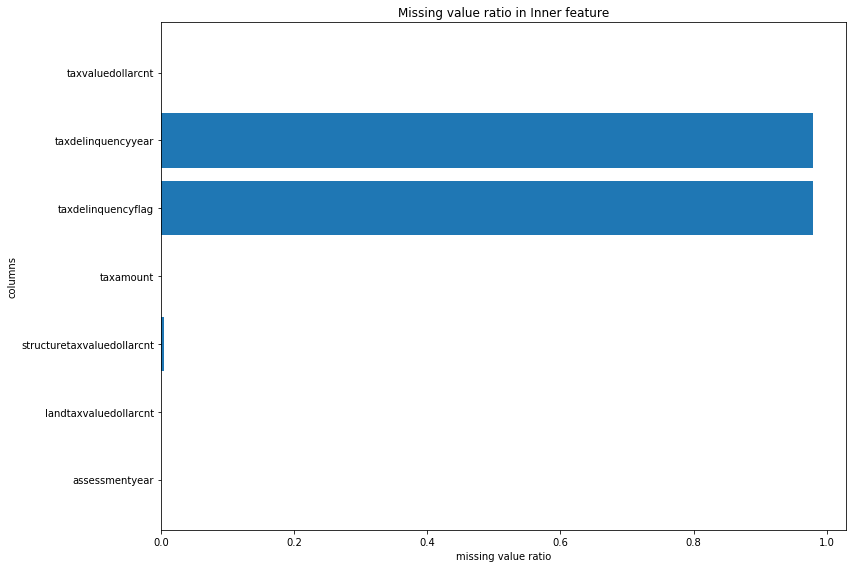

In [133]:
plt.figure(figsize=(12,8))
plt.barh(missing_tax_df.col,missing_tax_df.missing_ratio)
plt.title('Missing value ratio in Inner feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.4.1) Fill the Missing data - Tax-feature

In [134]:
missing_tax_df

,col,missing_cnt,missing_ratio
0,assessmentyear,0,0.000000
1,taxvaluedollarcnt,1,0.000011
2,landtaxvaluedollarcnt,1,0.000011
3,taxamount,6,0.000066
4,structuretaxvaluedollarcnt,380,0.004209
5,taxdelinquencyflag,88492,0.980249
6,taxdelinquencyyear,88492,0.980249


- 위의 missing_ratio를 보면 2개의 컬럼이 NaN값의 비율이 98%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data(categorical)
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

#### assessmentyear : 0.00%
- Description: 재산세 산정 년도
- Process: 2016년 주택의 재산세 산정 년도는 1년 전인 2015년만 존재하기 때문에, 정보력이 없다 `delete`

In [136]:
train_df.drop(columns='assessmentyear',inplace=True)
tax_feature_col.remove('assessmentyear')

#### taxvaluedollarcnt	 : 0.0011%
- Description: 소포의 총 세금 평가 가치
- Process: continuous data이며 missing_value_ratio가 매우 작은 것을 고려하면, 데이터가 누락된 것으로 예상된다. mean value로 filling 

In [137]:
train_df.taxvaluedollarcnt  = train_df.taxvaluedollarcnt .fillna(np.mean(train_df.taxvaluedollarcnt))

#### landtaxvaluedollarcnt	 : 0.0011%
- Description: 소포의 토지 면적에 대한 평가 된 가치
- Process: continuous data이며 missing_value_ratio가 매우 작은 것을 고려하면, 데이터가 누락된 것으로 예상된다. mean value로 filling 

In [138]:
train_df.landtaxvaluedollarcnt  = train_df.landtaxvaluedollarcnt .fillna(np.mean(train_df.landtaxvaluedollarcnt))

#### taxamount : 0.0066%
- Description: 해당 평가 연도에 대해 평가 된 총 재산세
- Process: continuous data이며 missing_value_ratio가 매우 작은 것을 고려하면, 데이터가 누락된 것으로 예상된다. mean value로 filling 

In [139]:
train_df.taxamount = train_df.taxamount.fillna(np.mean(train_df.taxamount))

#### structuretaxvaluedollarcnt	 : 0.4209%
- Description: 소포에 건설 된 구조물의 평가 된 가치
- Process: continuous data이며 가치 평가가 없는 데이터들은 누락된 것으로 간주, mean value로 filling 

In [140]:
train_df.structuretaxvaluedollarcnt = train_df.structuretaxvaluedollarcnt.fillna(np.mean(train_df.structuretaxvaluedollarcnt))

#### taxdelinquencyflag : 98.0249%
- Description: 이 소포의 재산세는 2015 년까지 만기가됩니다.
- Process: 데이터가 Y 하나밖에 없으므로 NaN값들을 N로 채워준다.

In [141]:
train_df.taxdelinquencyflag = train_df.taxdelinquencyflag.fillna('F')

#### taxdelinquencyyear	 : 98.0249%
- Description: 미납 된 재산세 납부시기
- Process: 주어진 데이터는 대표성을 가지지 못하므로 None으로 missing_value들을 채워준다.

In [142]:
train_df.taxdelinquencyyear = train_df.taxdelinquencyyear.fillna('None')

# 2.5) Analysis Missing value - SQFT-feature

#### SQFT-feature 내의 컬럼들로 구성된 데이터 프레임 'sqft_df'를 생성해보겠습니다.

In [143]:
sqrt_df = train_df[sqrt_feature_col]
sqrt_df.tail()

,basementsqft,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet6,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,lotsizesquarefeet,yardbuildingsqft17,yardbuildingsqft26
90270,NaN,NaN,653.0,NaN,653.0,NaN,NaN,NaN,93676.0,NaN,NaN
90271,NaN,NaN,2856.0,NaN,2856.0,NaN,NaN,NaN,9343.0,NaN,NaN
90272,NaN,NaN,2617.0,NaN,NaN,NaN,2617.0,NaN,6865.0,NaN,NaN
90273,NaN,NaN,1034.0,NaN,1034.0,NaN,NaN,NaN,20033.0,NaN,NaN
90274,NaN,NaN,1524.0,NaN,1524.0,NaN,NaN,NaN,5124.0,NaN,NaN


In [144]:
missing_sqrt_df = sqrt_df.isnull().sum().reset_index()
missing_sqrt_df.columns = ['col','missing_cnt']
missing_sqrt_df['missing_ratio'] = missing_sqrt_df.missing_cnt / len(sqrt_df)
missing_sqrt_df.sort_values(by='missing_ratio',inplace=True)
missing_sqrt_df.reset_index(drop=True,inplace=True)
missing_sqrt_df

,col,missing_cnt,missing_ratio
0,calculatedfinishedsquarefeet,661,0.007322
1,finishedsquarefeet12,4679,0.051831
2,lotsizesquarefeet,10150,0.112434
3,finishedfloor1squarefeet,83419,0.924054
4,finishedsquarefeet50,83419,0.924054
5,finishedsquarefeet15,86711,0.960521
6,yardbuildingsqft17,87629,0.970690
7,finishedsquarefeet6,89854,0.995336
8,yardbuildingsqft26,90180,0.998948
9,basementsqft,90232,0.999524


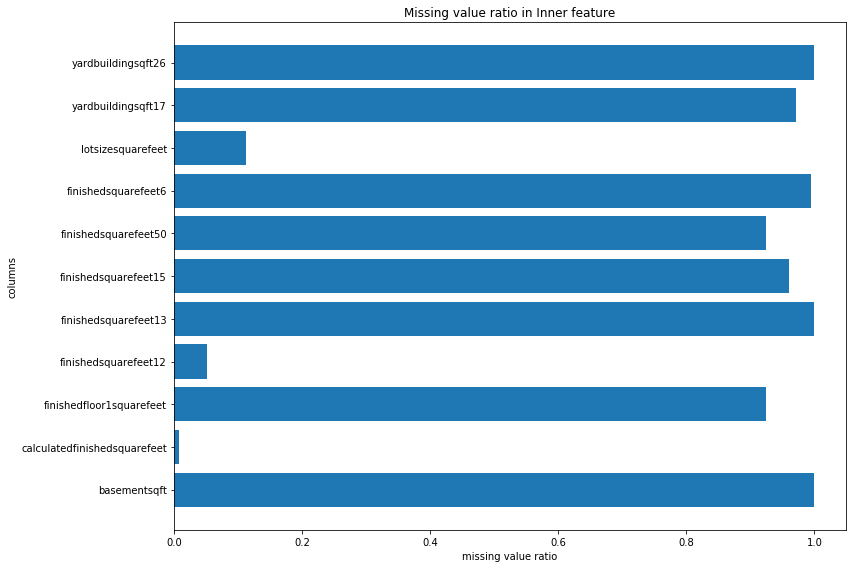

In [145]:
plt.figure(figsize=(12,8))
plt.barh(missing_sqrt_df.col,missing_sqrt_df.missing_ratio)
plt.title('Missing value ratio in Inner feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.5.1) Fill the Missing data - SQFT-feature

In [146]:
missing_sqrt_df

,col,missing_cnt,missing_ratio
0,calculatedfinishedsquarefeet,661,0.007322
1,finishedsquarefeet12,4679,0.051831
2,lotsizesquarefeet,10150,0.112434
3,finishedfloor1squarefeet,83419,0.924054
4,finishedsquarefeet50,83419,0.924054
5,finishedsquarefeet15,86711,0.960521
6,yardbuildingsqft17,87629,0.970690
7,finishedsquarefeet6,89854,0.995336
8,yardbuildingsqft26,90180,0.998948
9,basementsqft,90232,0.999524


- 위의 missing_ratio를 보면 3개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data , categorical data
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

- 데이터들을 살펴보게 되면, 면적이라는 numerical data라는 배경에 중복되는 데이터가 많다. 즉, 일종의 카테고리를 형성하고 있으며, 이는 건물들이 일정한 면적의 기준 형식을 따르고 있음을 알 수 있다.
- 이에 따라서 missing_value에 mode를 넣을 것인지 mean값을 넣을 것인지에 대해서 결정해야 한다.

#### calculatedfinishedsquarefeet	 : 0.7322%
- Description: 가정 내의 완성된 거실 수
- Process: 아래의 통계치를 보게 되면 ,1200 면적이 188개로 가장 많이 나온다.(상대적으로 가장 일반적) 따라서 missing data 에 mode값을 채워준다.

In [147]:
train_df.calculatedfinishedsquarefeet = train_df.calculatedfinishedsquarefeet.fillna(train_df.calculatedfinishedsquarefeet.mode()[0])

#### finishedsquarefeet12	 :5.1831%
- Description: 완성된 거실
- Process: 해당 컬럼은 위에서 다뤘던 컬럼보다 카테고리가 더 적다. 즉, 특정 면적에 속한 건물이 더 많다는 것이다. missing_data에 mode값으로 채워준다.

In [148]:
train_df.finishedsquarefeet12 = train_df.finishedsquarefeet12.fillna(train_df.finishedsquarefeet12.mode()[0])

#### lotsizesquarefeet	 : 11.2434%
- Description: 로트 면적(lot는 area of zoning lot을 의미한다.)
- Process: 통계치를 보면 6000.0 의 면적에 많은 건물들이 속함을 알 수 있다. mode filling.

In [149]:
train_df.lotsizesquarefeet = train_df.lotsizesquarefeet.fillna(train_df.lotsizesquarefeet.mode()[0])

#### finishedfloor1squarefeet	 : 92.4054%
- Description: 가정 내의 1층에 있는 거실의 크기
- Process: 해당 데이터는 뚜렷한 최빈값이 없다.따라서 None으로 채워준다.

In [150]:
train_df.finishedfloor1squarefeet = train_df.finishedfloor1squarefeet.fillna('None')

#### finishedsquarefeet50	 : 96.0521%
- Description: 1층의 크기
- Process: 해당 컬럼도 뚜렷한 최빈값이 없다. 따라서 평균값으로 채워준다.

In [151]:
train_df.finishedsquarefeet50 = train_df.finishedsquarefeet50.fillna('None')

#### finishedsquarefeet15	 : 99.5336%
- Description: 전체 면적
- Process: 통계치를 보게 되면 중복되는 값들을 많지 않고, 극단치의 값들의 영향이 적지 않다. 따라서 mode값으로 채워준다. 하지만, 이 최빈값도 기존의 데이터가 많지 않아서 영향력이 없다고 할 수 있다. 삭제하는 것이 더욱 안전하다.

In [152]:
train_df.finishedsquarefeet15 = train_df.finishedsquarefeet15.fillna('None')

#### finishedsquarefeet6	 : 99.5336%
- Description: 기초 미완성 및 완공 지역
- Process: 데이터의 수가 너무 적어서 최빈값도 평균값도 영향력이 없다. None으로 채워준다.

In [153]:
train_df.finishedsquarefeet6 = train_df.finishedsquarefeet6.fillna('None')

#### basementsqft	 : 99.9524%
- Description: 지하 층 면적
- Process: 데이터의 수가 너무 적어서 최빈값도 평균값도 영향력이 없다. 삭제하는 것이 안전하다.

In [154]:
train_df.basementsqft = train_df.basementsqft.fillna('None')

#### finishedsquarefeet13	 : 99.9634%
- Description: 주변 생활 공간 면적
- Process: 데이터의 수가 너무 적어서 최빈값도 평균값도 영향력이 없다. 삭제하는 것이 안전하다.

In [155]:
train_df.finishedsquarefeet13 = train_df.finishedsquarefeet13.fillna('None')